# Diabetes Readmission Prediction (Class Weights Only)

## Project Overview

**Primary Goal:** Predict whether a diabetic patient will be readmitted to the hospital within 30 days of discharge.

**Secondary Goal:** Identify and understand the key factors contributing to readmission risk using explainable AI techniques.

**Dataset:** Diabetes 130-US Hospitals (1999-2008) from UCI ML Repository
- Over 100,000 patient encounters
- Highly imbalanced (~11% readmitted within 30 days)


## 1. Import Libraries & Configuration

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# Evaluation Metrics
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    recall_score, 
    precision_score, 
    f1_score
)

# Explainability
import shap

# Other utilities
import warnings

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set random seed for reproducibility
RANDOM_STATE = 42

print("✅ All libraries imported successfully!")
print("📝 Note: SMOTE NOT imported - using class weights only for imbalance handling")

✅ All libraries imported successfully!
📝 Note: SMOTE NOT imported - using class weights only for imbalance handling


## 2. Load and Explore the Dataset

In [3]:
# Load the dataset
print("Loading data from 'diabetic_data.csv'...")
df = pd.read_csv('diabetic_data.csv')

print(f"\n✅ Dataset loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")

# Display first few rows
df.head()

Loading data from 'diabetic_data.csv'...

✅ Dataset loaded successfully!
Shape: 101,766 rows × 50 columns



,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Basic dataset information
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  in

In [5]:
# Check for missing values (represented as '?')
print("Checking for missing values ('?' placeholders):")
missing_counts = (df == '?').sum()
missing_pct = (missing_counts / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Percentage', ascending=False)
print(missing_df)

Checking for missing values ('?' placeholders):
                   Missing Count  Percentage
weight                     98569       96.86
medical_specialty          49949       49.08
payer_code                 40256       39.56
race                        2273        2.23
diag_3                      1423        1.40
diag_2                       358        0.35
diag_1                        21        0.02



Original 'readmitted' column distribution:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

Proportions:
readmitted
NO     0.5391
>30    0.3493
<30    0.1116
Name: proportion, dtype: float64


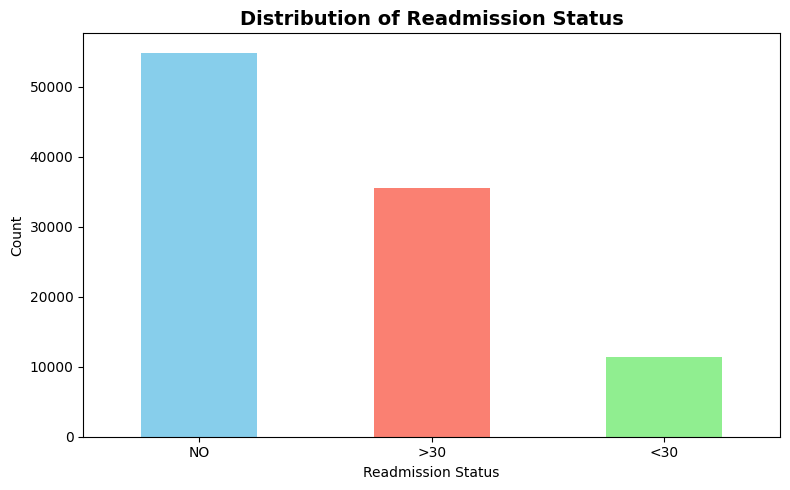

In [6]:
# Examine the target variable distribution
print("\nOriginal 'readmitted' column distribution:")
print(df['readmitted'].value_counts())
print("\nProportions:")
print(df['readmitted'].value_counts(normalize=True).round(4))

# Visualize
plt.figure(figsize=(8, 5))
df['readmitted'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Readmission Status', fontsize=14, fontweight='bold')
plt.xlabel('Readmission Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Data Cleaning & Preparation

In [7]:
# Replace '?' with NaN for consistent missing value handling
df.replace('?', np.nan, inplace=True)
print("✅ Replaced '?' placeholders with NaN")

# Drop columns with >40% missing values or low relevance
columns_to_drop = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
df.drop(columns=columns_to_drop, inplace=True)
print(f"✅ Dropped {len(columns_to_drop)} columns: {columns_to_drop}")

# Drop rows where primary diagnosis is missing
rows_before = len(df)
df.dropna(subset=['diag_1'], inplace=True)
print(f"✅ Dropped {rows_before - len(df)} rows with missing primary diagnosis")

# Clean gender column
rows_before = len(df)
df = df[df['gender'] != 'Unknown/Invalid']
print(f"✅ Removed {rows_before - len(df)} rows with invalid gender")

print(f"\n📊 Final dataset shape: {df.shape}")

✅ Replaced '?' placeholders with NaN
✅ Dropped 5 columns: ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
✅ Dropped 21 rows with missing primary diagnosis
✅ Removed 3 rows with invalid gender

📊 Final dataset shape: (101742, 45)


## 4. Target Variable Creation

Convert the 3-class readmission variable into a binary target:
- **1** = Readmitted within 30 days (`<30`)
- **0** = Not readmitted within 30 days (`>30` or `NO`)

✅ Target variable 'target' created

Class distribution:
target
0    90390
1    11352
Name: count, dtype: int64

Class proportions:
target
0    0.8884
1    0.1116
Name: proportion, dtype: float64


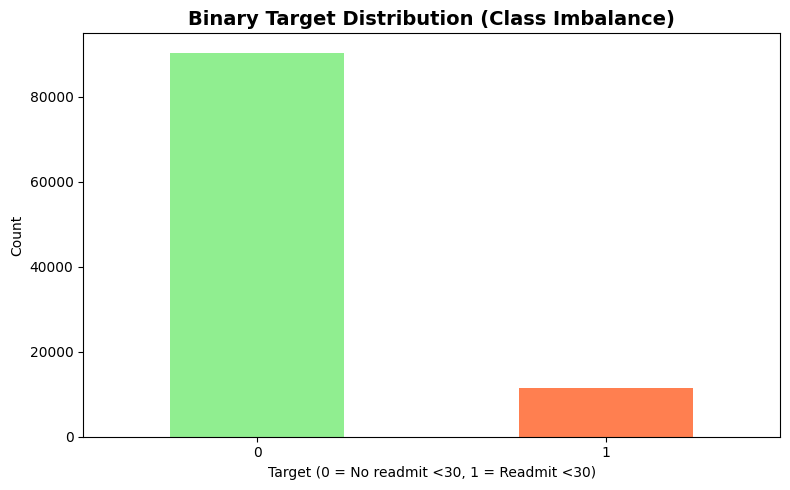


⚠️ Class imbalance detected: 11.16% are readmitted <30 days


In [8]:
# Create binary target variable
df['target'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df.drop(columns=['readmitted'], inplace=True)

print("✅ Target variable 'target' created")
print("\nClass distribution:")
print(df['target'].value_counts())
print("\nClass proportions:")
print(df['target'].value_counts(normalize=True).round(4))

# Visualize class imbalance
plt.figure(figsize=(8, 5))
df['target'].value_counts().plot(kind='bar', color=['lightgreen', 'coral'])
plt.title('Binary Target Distribution (Class Imbalance)', fontsize=14, fontweight='bold')
plt.xlabel('Target (0 = No readmit <30, 1 = Readmit <30)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\n⚠️ Class imbalance detected: {(df['target'].sum() / len(df) * 100):.2f}% are readmitted <30 days")

## 5. Feature Engineering - ICD-9 Diagnosis Code Mapping

Group specific ICD-9 diagnosis codes into broader clinical categories to reduce dimensionality and improve model performance.

In [9]:
def map_diagnosis_codes(df):
    """
    Engineers new features by grouping ICD-9 diagnosis codes into clinical categories.
    """
    df_new = df.copy()

    # Define ICD-9 code ranges for major categories
    diag_code_ranges = {
        'Infectious': (1, 139),
        'Neoplasms': (140, 239),
        'Endocrine/Metabolic': (240, 279),
        'Blood': (280, 289),
        'Mental': (290, 319),
        'Nervous': (320, 389),
        'Circulatory': (390, 459),
        'Respiratory': (460, 519),
        'Digestive': (520, 579),
        'Genitourinary': (580, 629),
        'Pregnancy': (630, 679),
        'Skin': (680, 709),
        'Musculoskeletal': (710, 739),
        'Congenital': (740, 759),
        'Perinatal': (760, 779),
        'Symptoms/Ill-defined': (780, 799),
        'Injury/Poisoning': (800, 999),
        'External_Cause': (1000, 2000),
        'Other': (0, 0)
    }

    def get_category(diag_code):
        if pd.isna(diag_code):
            return 'Unknown'

        # Handle 'E' and 'V' codes
        if diag_code.startswith('E'):
            return 'External_Cause'
        if diag_code.startswith('V'):
            return 'Supplementary'

        try:
            code = float(diag_code)
            # Special case for diabetes
            if 250 <= code < 251:
                return 'Diabetes'
            
            for category, (start, end) in diag_code_ranges.items():
                if start <= code <= end:
                    return category
            return 'Other'
        except ValueError:
            return 'Unknown'

    # Apply mapping to all three diagnosis columns
    for col in ['diag_1', 'diag_2', 'diag_3']:
        new_col_name = f'{col}_category'
        df_new[new_col_name] = df_new[col].apply(get_category)

    return df_new

# Apply feature engineering
print("Applying ICD-9 diagnosis code mapping...")
df = map_diagnosis_codes(df)
print("✅ Feature engineering complete. Created diagnosis categories.")

# Show sample of new features
print("\nSample of original codes and their categories:")
df[['diag_1', 'diag_1_category', 'diag_2', 'diag_2_category', 'diag_3', 'diag_3_category']].head(10)

Applying ICD-9 diagnosis code mapping...
✅ Feature engineering complete. Created diagnosis categories.

Sample of original codes and their categories:


,diag_1,diag_1_category,diag_2,diag_2_category,diag_3,diag_3_category
0,250.83,Diabetes,NaN,Unknown,NaN,Unknown
1,276,Endocrine/Metabolic,250.01,Diabetes,255,Endocrine/Metabolic
2,648,Pregnancy,250,Diabetes,V27,Supplementary
3,8,Infectious,250.43,Diabetes,403,Circulatory
4,197,Neoplasms,157,Neoplasms,250,Diabetes
5,414,Circulatory,411,Circulatory,250,Diabetes
6,414,Circulatory,411,Circulatory,V45,Supplementary
7,428,Circulatory,492,Respiratory,250,Diabetes
8,398,Circulatory,427,Circulatory,38,Infectious
9,434,Circulatory,198,Neoplasms,486,Respiratory


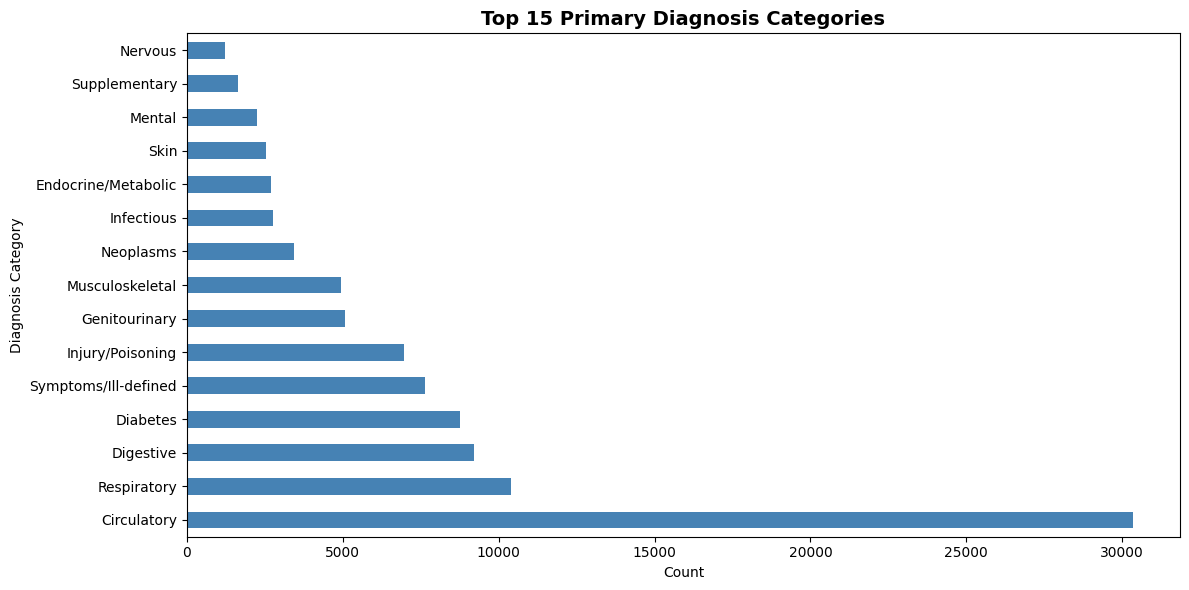

In [10]:
# Visualize distribution of primary diagnosis categories
plt.figure(figsize=(12, 6))
df['diag_1_category'].value_counts().head(15).plot(kind='barh', color='steelblue')
plt.title('Top 15 Primary Diagnosis Categories', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Diagnosis Category')
plt.tight_layout()
plt.show()

In [11]:
# Drop original diagnosis code columns (now using categories)
df.drop(columns=['diag_1', 'diag_2', 'diag_3'], inplace=True)
print("✅ Dropped original diagnosis code columns (using engineered categories instead)")

✅ Dropped original diagnosis code columns (using engineered categories instead)


## 6. Define Feature Lists & Preprocessing Pipeline

In [12]:
# Define medication features
med_features = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]

# Define numerical features
numerical_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

# Define categorical features
categorical_features = [
    'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed',
    'diag_1_category', 'diag_2_category', 'diag_3_category'
] + med_features

# Verify all features exist in dataframe
all_features = numerical_features + categorical_features
missing_features = [f for f in all_features if f not in df.columns]

if missing_features:
    print(f"⚠️ Warning: Missing features: {missing_features}")
    numerical_features = [f for f in numerical_features if f in df.columns]
    categorical_features = [f for f in categorical_features if f in df.columns]

print(f"\n📊 Feature Summary:")
print(f"   Numerical features: {len(numerical_features)}")
print(f"   Categorical features: {len(categorical_features)}")
print(f"   Total features: {len(numerical_features) + len(categorical_features)}")


📊 Feature Summary:
   Numerical features: 8
   Categorical features: 36
   Total features: 44


In [13]:
# Create feature matrix (X) and target vector (y)
X = df[numerical_features + categorical_features]
y = df['target']

print(f"✅ Feature matrix created: {X.shape}")
print(f"✅ Target vector created: {y.shape}")

✅ Feature matrix created: (101742, 44)
✅ Target vector created: (101742,)


In [14]:
# Create preprocessing pipelines
print("Building preprocessing pipeline...\n")

# Numerical transformer: Scale numerical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combined preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("✅ Preprocessing pipeline created:")
print("   - Numerical: StandardScaler")
print("   - Categorical: Imputation + OneHotEncoding")

Building preprocessing pipeline...

✅ Preprocessing pipeline created:
   - Numerical: StandardScaler
   - Categorical: Imputation + OneHotEncoding


In [15]:
# Apply preprocessing
print("Applying preprocessing pipeline...")
X_processed = preprocessor.fit_transform(X)
print(f"✅ Preprocessing complete!")
print(f"   Original shape: {X.shape}")
print(f"   Processed shape: {X_processed.shape}")
print(f"   (One-hot encoding expanded categorical features)")

# Get feature names after preprocessing
try:
    feature_names = preprocessor.get_feature_names_out()
    feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]
    print(f"✅ Extracted {len(feature_names)} feature names")
except Exception as e:
    print(f"⚠️ Could not extract feature names: {e}")
    feature_names = [f'feature_{i}' for i in range(X_processed.shape[1])]

Applying preprocessing pipeline...
✅ Preprocessing complete!
   Original shape: (101742, 44)
   Processed shape: (101742, 216)
   (One-hot encoding expanded categorical features)
✅ Extracted 216 feature names


## 7. Train-Test Split (WITHOUT SMOTE)

**KEY DIFFERENCE:** We split the data but **DO NOT apply SMOTE**. Models will learn from the original imbalanced distribution and use class weights to handle imbalance during training.

In [16]:
# Split data into train and test sets (80/20 split)
print("Splitting data into train and test sets (80/20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"\n✅ Data split complete:")
print(f"   Training set: {X_train.shape[0]:,} samples")
print(f"   Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print("\nProportions:")
print(y_train.value_counts(normalize=True).round(4))

print("\n" + "="*70)
print("🚫 SMOTE NOT APPLIED - Using original imbalanced training data")
print("✅ Models will use class_weight parameters to handle imbalance")
print("="*70)

Splitting data into train and test sets (80/20)...

✅ Data split complete:
   Training set: 81,393 samples
   Test set: 20,349 samples

Training set class distribution:
target
0    72311
1     9082
Name: count, dtype: int64

Proportions:
target
0    0.8884
1    0.1116
Name: proportion, dtype: float64

🚫 SMOTE NOT APPLIED - Using original imbalanced training data
✅ Models will use class_weight parameters to handle imbalance


In [17]:
# Prepare data in different formats for different models
print("\nPreparing data for different model types...")

# Dense arrays for Gaussian Naive Bayes
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# DataFrames for tree-based models (Random Forest, LightGBM)
# Clean feature names for LightGBM compatibility
lgbm_feature_names = [name.replace('[', '').replace(']', '').replace('<', '') for name in feature_names]
X_train_df = pd.DataFrame(X_train_dense, columns=lgbm_feature_names)
X_test_df = pd.DataFrame(X_test_dense, columns=lgbm_feature_names)

print("✅ Data prepared for all model types")


Preparing data for different model types...
✅ Data prepared for all model types


## 8. Model Training & Evaluation

We'll train and compare 4 models with **class weight parameters** to handle imbalance:
1. **Logistic Regression** - with `class_weight='balanced'`
2. **Gaussian Naive Bayes** - no class weights (probabilistic approach)
3. **Random Forest** - with `class_weight='balanced'`
4. **LightGBM** - with `is_unbalance=True`

In [18]:
# Helper function for plotting confusion matrices
def plot_confusion_matrix_heatmap(cm, title, class_names=['Not Readmitted', 'Readmitted <30']):
    """
    Plots a confusion matrix as a heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Storage for model results
model_results = {}

print("✅ Helper function and results storage created")

✅ Helper function and results storage created


### Model 1: Logistic Regression (with class_weight='balanced')

Training Model 1: Logistic Regression (Baseline)

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.93      0.68      0.79     18079
           1       0.18      0.56      0.28      2270

    accuracy                           0.67     20349
   macro avg       0.55      0.62      0.53     20349
weighted avg       0.84      0.67      0.73     20349



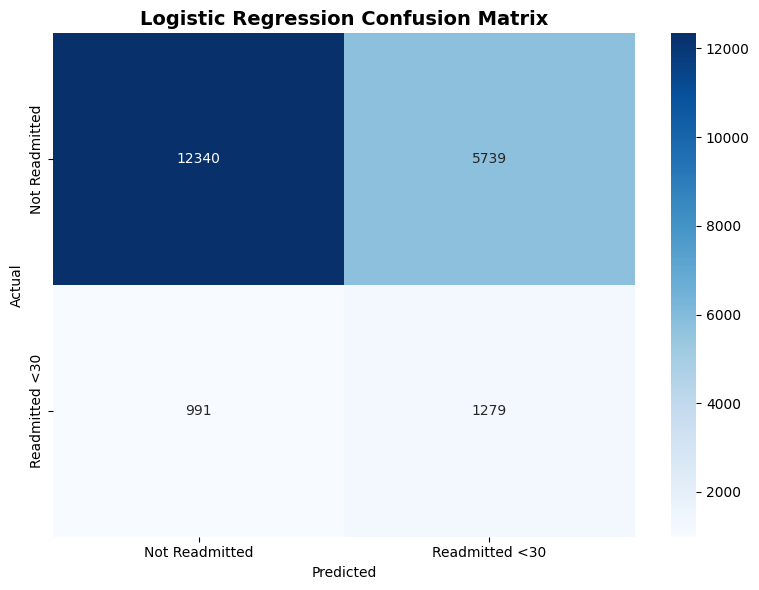


✅ Logistic Regression training complete


In [19]:
print("="*60)
print("Training Model 1: Logistic Regression (Baseline)")
print("="*60)

# Train model with class_weight='balanced' to handle imbalanced data
log_reg = LogisticRegression(
    random_state=RANDOM_STATE, 
    max_iter=1000,
    class_weight='balanced'  # Automatically adjusts weights inversely proportional to class frequencies
)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log = log_reg.predict(X_test)
y_pred_proba_log = log_reg.predict_proba(X_test)[:, 1]

# Evaluate
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_log))

# Store results
model_results['Logistic Regression'] = {
    'AUC': roc_auc_score(y_test, y_pred_proba_log),
    'Recall (Class 1)': recall_score(y_test, y_pred_log, pos_label=1),
    'Precision (Class 1)': precision_score(y_test, y_pred_log, pos_label=1),
    'F1-score (Class 1)': f1_score(y_test, y_pred_log, pos_label=1)
}

# Plot confusion matrix
cm_log = confusion_matrix(y_test, y_pred_log)
plot_confusion_matrix_heatmap(cm_log, 'Logistic Regression Confusion Matrix')

print("\n✅ Logistic Regression training complete")

### Model 2: Gaussian Naive Bayes (no class weights needed)

Training Model 2: Gaussian Naive Bayes (Baseline)



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.97      0.04      0.07     18079
           1       0.11      0.99      0.20      2270

    accuracy                           0.14     20349
   macro avg       0.54      0.51      0.14     20349
weighted avg       0.87      0.14      0.09     20349



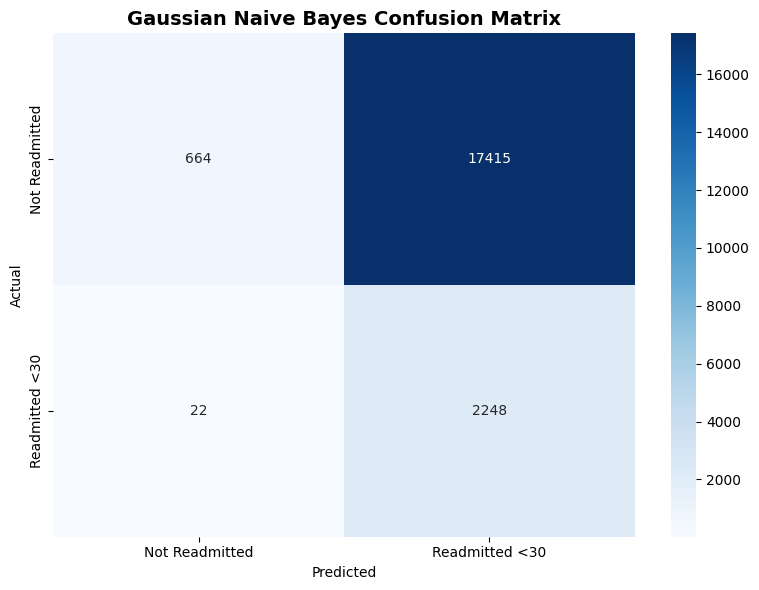


✅ Gaussian Naive Bayes training complete


In [20]:
print("="*60)
print("Training Model 2: Gaussian Naive Bayes (Baseline)")
print("="*60)

# Train model (Naive Bayes naturally handles imbalance through probability estimation)
gnb = GaussianNB()
gnb.fit(X_train_dense, y_train)

# Make predictions
y_pred_gnb = gnb.predict(X_test_dense)
y_pred_proba_gnb = gnb.predict_proba(X_test_dense)[:, 1]

# Evaluate
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_gnb))

# Store results
model_results['Gaussian Naive Bayes'] = {
    'AUC': roc_auc_score(y_test, y_pred_proba_gnb),
    'Recall (Class 1)': recall_score(y_test, y_pred_gnb, pos_label=1),
    'Precision (Class 1)': precision_score(y_test, y_pred_gnb, pos_label=1),
    'F1-score (Class 1)': f1_score(y_test, y_pred_gnb, pos_label=1)
}

# Plot confusion matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
plot_confusion_matrix_heatmap(cm_gnb, 'Gaussian Naive Bayes Confusion Matrix')

print("\n✅ Gaussian Naive Bayes training complete")

### Model 3: Random Forest (with class_weight='balanced')

Training Model 3: Random Forest (Advanced)

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     18079
           1       0.24      0.21      0.22      2270

    accuracy                           0.84     20349
   macro avg       0.57      0.56      0.57     20349
weighted avg       0.83      0.84      0.83     20349



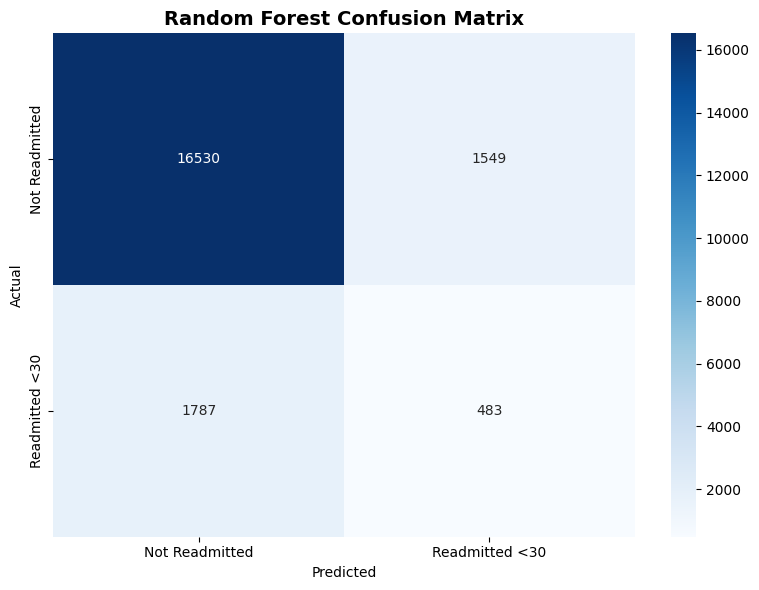


✅ Random Forest training complete


In [21]:
print("="*60)
print("Training Model 3: Random Forest (Advanced)")
print("="*60)

# Train model with class_weight='balanced' to handle imbalanced data
rf = RandomForestClassifier(
    random_state=RANDOM_STATE, 
    n_estimators=150, 
    class_weight='balanced',  # Balances class weights automatically
    n_jobs=-1, 
    max_depth=20
)
rf.fit(X_train_df, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test_df)
y_pred_proba_rf = rf.predict_proba(X_test_df)[:, 1]

# Evaluate
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_rf))

# Store results
model_results['Random Forest'] = {
    'AUC': roc_auc_score(y_test, y_pred_proba_rf),
    'Recall (Class 1)': recall_score(y_test, y_pred_rf, pos_label=1),
    'Precision (Class 1)': precision_score(y_test, y_pred_rf, pos_label=1),
    'F1-score (Class 1)': f1_score(y_test, y_pred_rf, pos_label=1)
}

# Plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix_heatmap(cm_rf, 'Random Forest Confusion Matrix')

print("\n✅ Random Forest training complete")

### Model 4: LightGBM (with is_unbalance=True)

Training Model 4: LightGBM (Advanced)
[LightGBM] [Info] Number of positive: 9082, number of negative: 72311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 81393, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111582 -> initscore=-2.074682
[LightGBM] [Info] Start training from score -2.074682

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.93      0.67      0.78     18079
           1       0.18      0.59      0.28      2270

    accuracy                           0.66     20349
   macro avg       0.56      0.63      0.53     20349
weighted avg       0.84      0.66      0.72     20349



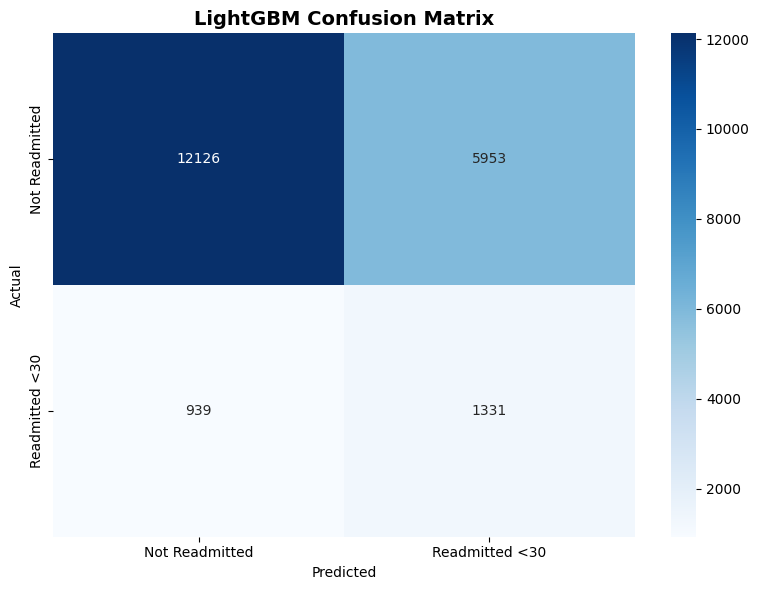


✅ LightGBM training complete


In [22]:
print("="*60)
print("Training Model 4: LightGBM (Advanced)")
print("="*60)

# Train model with is_unbalance=True to handle imbalanced data
lgbm = lgb.LGBMClassifier(
    random_state=RANDOM_STATE, 
    is_unbalance=True,  # Tells LightGBM to handle imbalanced data
    n_estimators=200, 
    learning_rate=0.05, 
    num_leaves=31
)
lgbm.fit(X_train_df, y_train)

# Make predictions
y_pred_lgbm = lgbm.predict(X_test_df)
y_pred_proba_lgbm = lgbm.predict_proba(X_test_df)[:, 1]

# Evaluate
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_lgbm))

# Store results
model_results['LightGBM'] = {
    'AUC': roc_auc_score(y_test, y_pred_proba_lgbm),
    'Recall (Class 1)': recall_score(y_test, y_pred_lgbm, pos_label=1),
    'Precision (Class 1)': precision_score(y_test, y_pred_lgbm, pos_label=1),
    'F1-score (Class 1)': f1_score(y_test, y_pred_lgbm, pos_label=1)
}

# Plot confusion matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plot_confusion_matrix_heatmap(cm_lgbm, 'LightGBM Confusion Matrix')

print("\n✅ LightGBM training complete")

## 9. Model Comparison

Compare all 4 models side-by-side to identify the best performer.

In [23]:
# Remove LightGBM (Optimized) from comparison to show only the 4 main models
if 'LightGBM (Optimized)' in model_results:
    del model_results['LightGBM (Optimized)']
    print("✅ Removed 'LightGBM (Optimized)' from comparison")
    print("📊 Showing only the 4 main models: Logistic Regression, Gaussian Naive Bayes, Random Forest, LightGBM")
else:
    print("✅ Model results ready for comparison")

✅ Model results ready for comparison


In [24]:
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60 + "\n")

# Create comparison DataFrame
results_df = pd.DataFrame.from_dict(model_results, orient='index')
results_df = results_df.sort_values(by='AUC', ascending=False)

# Round values for better display
results_df = results_df.round(4)

print(results_df)
print("\n" + "="*60)

# Identify best model
best_model_name = results_df.index[0]
print(f"\n🏆 Best Model (by AUC): {best_model_name}")
print(f"   AUC Score: {results_df.loc[best_model_name, 'AUC']:.4f}")

print("\n📊 Performance Summary:")
print("="*60)
for model_name in results_df.index:
    print(f"\n{model_name}:")
    print(f"  AUC: {results_df.loc[model_name, 'AUC']:.4f}")
    print(f"  Recall: {results_df.loc[model_name, 'Recall (Class 1)']:.4f}")
    print(f"  Precision: {results_df.loc[model_name, 'Precision (Class 1)']:.4f}")
    print(f"  F1-Score: {results_df.loc[model_name, 'F1-score (Class 1)']:.4f}")


FINAL MODEL COMPARISON

                         AUC  Recall (Class 1)  Precision (Class 1)  \
LightGBM              0.6791            0.5863               0.1827   
Logistic Regression   0.6739            0.5634               0.1822   
Random Forest         0.6615            0.2128               0.2377   
Gaussian Naive Bayes  0.5142            0.9903               0.1143   

                      F1-score (Class 1)  
LightGBM                          0.2786  
Logistic Regression               0.2754  
Random Forest                     0.2245  
Gaussian Naive Bayes              0.2050  


🏆 Best Model (by AUC): LightGBM
   AUC Score: 0.6791

📊 Performance Summary:

LightGBM:
  AUC: 0.6791
  Recall: 0.5863
  Precision: 0.1827
  F1-Score: 0.2786

Logistic Regression:
  AUC: 0.6739
  Recall: 0.5634
  Precision: 0.1822
  F1-Score: 0.2754

Random Forest:
  AUC: 0.6615
  Recall: 0.2128
  Precision: 0.2377
  F1-Score: 0.2245

Gaussian Naive Bayes:
  AUC: 0.5142
  Recall: 0.9903
  Precision:

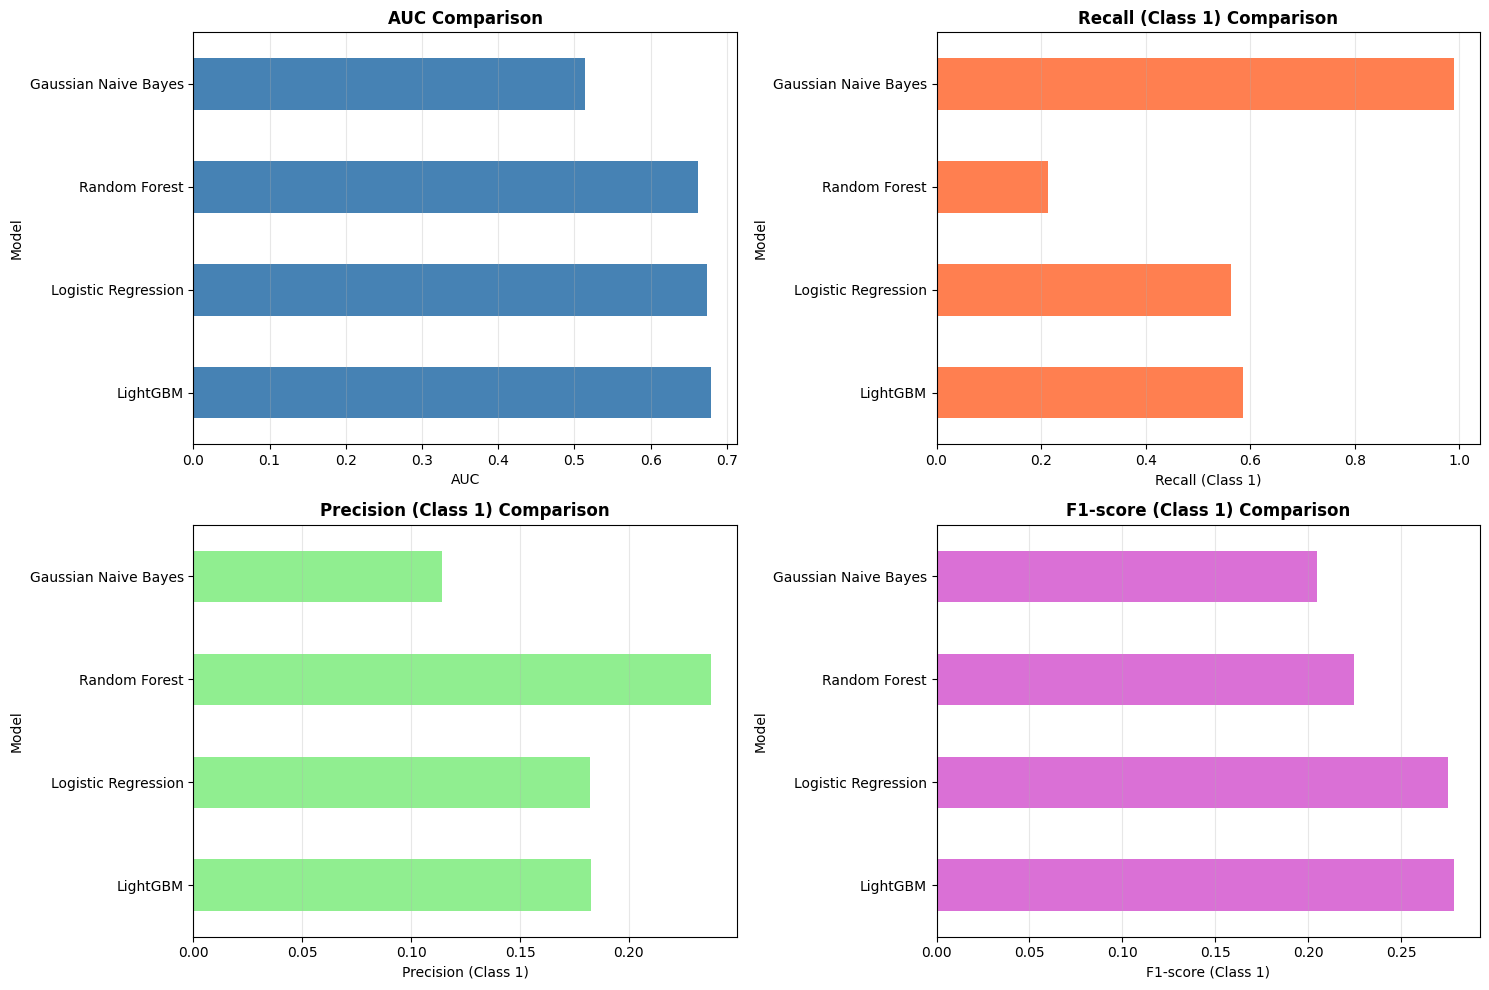

In [25]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['AUC', 'Recall (Class 1)', 'Precision (Class 1)', 'F1-score (Class 1)']
colors = ['steelblue', 'coral', 'lightgreen', 'orchid']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    results_df[metric].plot(kind='barh', ax=ax, color=color)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlabel(metric)
    ax.set_ylabel('Model')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Best Model for SHAP


In [26]:
# Select best model for SHAP analysis
if model_results['LightGBM']['AUC'] >= model_results['Random Forest']['AUC']:
    print("\n✅ LightGBM performed best. Proceeding with LightGBM for explainability analysis.")
    best_model = lgbm
    best_model_name = 'LightGBM'
else:
    print("\n✅ Random Forest performed best. Proceeding with Random Forest for explainability analysis.")
    best_model = rf
    best_model_name = 'Random Forest'


✅ LightGBM performed best. Proceeding with LightGBM for explainability analysis.


## 11. Model Explainability with SHAP

Use SHAP (SHapley Additive exPlanations) to understand which features drive the model's predictions.

In [27]:
print("="*60)
print(f"Generating SHAP Explanations for {best_model_name}")
print("="*60)

# Initialize SHAP explainer (TreeExplainer for tree-based models)
print("\nInitializing SHAP TreeExplainer...")
explainer = shap.TreeExplainer(best_model)
print("✅ SHAP explainer initialized")

# Use a sample for faster computation
sample_size = min(1000, len(X_train_df))
X_train_sample = X_train_df.sample(n=sample_size, random_state=RANDOM_STATE)

print(f"\nCalculating SHAP values on {sample_size} training samples...")
print("(This may take a few minutes...)")
shap_values = explainer.shap_values(X_train_sample)

# For binary classification, SHAP returns a list of arrays
# We want the SHAP values for the positive class (Class 1: Readmitted)
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

print("✅ SHAP values calculated successfully")

Generating SHAP Explanations for LightGBM

Initializing SHAP TreeExplainer...
✅ SHAP explainer initialized

Calculating SHAP values on 1000 training samples...
(This may take a few minutes...)
✅ SHAP values calculated successfully


In [28]:
# Display SHAP values for inspection
print("\n" + "="*60)
print("SHAP VALUES SUMMARY")
print("="*60)

# Display shape of SHAP values
print(f"\n📊 SHAP Values Array Shape: {shap_values_class1.shape}")
print(f"   - {shap_values_class1.shape[0]} samples")
print(f"   - {shap_values_class1.shape[1]} features")

# Calculate mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)

# Create a DataFrame with feature importance
shap_importance_df = pd.DataFrame({
    'Feature': lgbm_feature_names,
    'Mean |SHAP Value|': mean_abs_shap
}).sort_values('Mean |SHAP Value|', ascending=False)

# Display top 20 most important features
print("\n🏆 Top 20 Most Important Features (by Mean Absolute SHAP Value):")
print("="*60)
print(shap_importance_df.head(20).to_string(index=False))

# Display sample of actual SHAP values for first 5 instances
print("\n\n📋 Sample SHAP Values (First 5 Instances, Top 10 Features):")
print("="*60)
top_10_features_idx = shap_importance_df.head(10).index.tolist()
sample_shap_df = pd.DataFrame(
    shap_values_class1[:5, top_10_features_idx],
    columns=[lgbm_feature_names[i] for i in top_10_features_idx]
)
sample_shap_df.index.name = 'Sample'
print(sample_shap_df.round(4).to_string())

print("\n💡 Interpretation:")
print("   - Positive SHAP value = increases readmission probability")
print("   - Negative SHAP value = decreases readmission probability")
print("   - Larger absolute value = stronger effect on prediction")


SHAP VALUES SUMMARY

📊 SHAP Values Array Shape: (1000, 216)
   - 1000 samples
   - 216 features

🏆 Top 20 Most Important Features (by Mean Absolute SHAP Value):
                             Feature  Mean |SHAP Value|
                    number_inpatient           0.296997
         discharge_disposition_id_11           0.192078
          discharge_disposition_id_1           0.171982
                    number_diagnoses           0.063371
                      diabetesMed_No           0.057593
         diag_1_category_Circulatory           0.053947
                    time_in_hospital           0.043855
                          age_50-60)           0.040746
                     num_medications           0.038838
                  num_lab_procedures           0.037424
                    number_emergency           0.030699
                        metformin_No           0.028147
         discharge_disposition_id_22           0.025324
diag_1_category_Symptoms/Ill-defined           0.02134


Generating SHAP Summary Plot (Top 20 Features)...



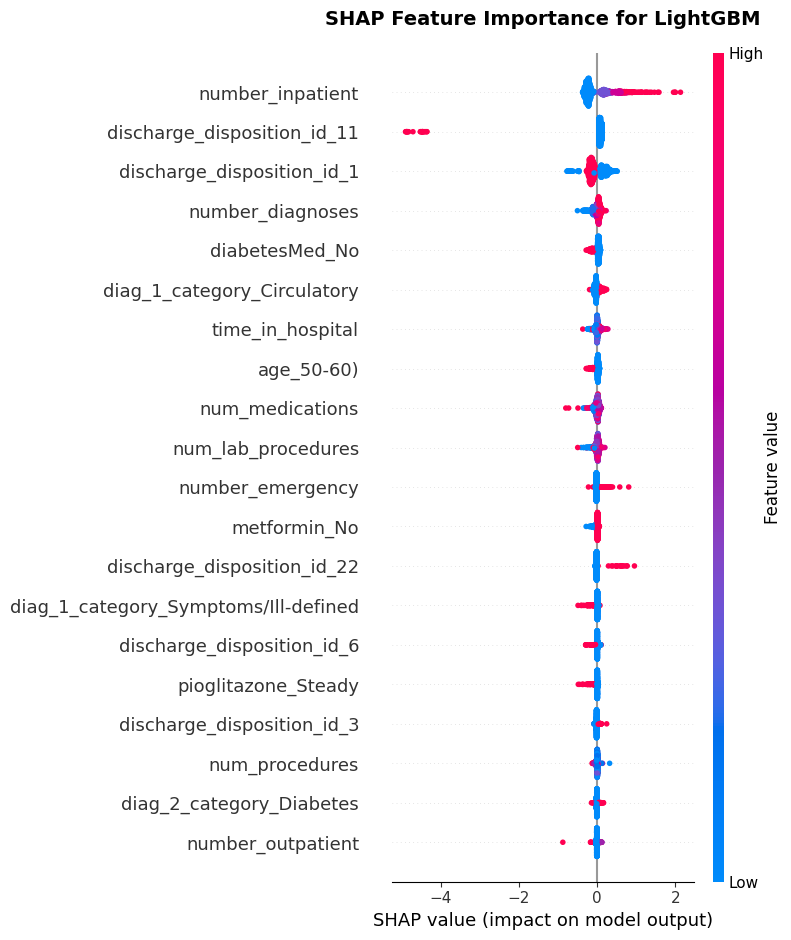


✅ SHAP analysis complete!

📊 Interpretation:
   - Features at the top are most important for predictions
   - Red (high feature value) vs Blue (low feature value)
   - Points to the right increase readmission risk
   - Points to the left decrease readmission risk


In [29]:
# Plot SHAP Summary Plot (Global Feature Importance)
print("\nGenerating SHAP Summary Plot (Top 20 Features)...\n")

plt.figure(figsize=(12, 8))
plt.title(f'SHAP Feature Importance for {best_model_name}', fontsize=14, fontweight='bold', pad=20)
shap.summary_plot(
    shap_values_class1, 
    X_train_sample,
    feature_names=lgbm_feature_names,
    max_display=20,
    show=False
)
plt.tight_layout()
plt.show()

print("\n✅ SHAP analysis complete!")
print("\n📊 Interpretation:")
print("   - Features at the top are most important for predictions")
print("   - Red (high feature value) vs Blue (low feature value)")
print("   - Points to the right increase readmission risk")
print("   - Points to the left decrease readmission risk")


Generating SHAP Bar Plot (Mean Feature Importance)...



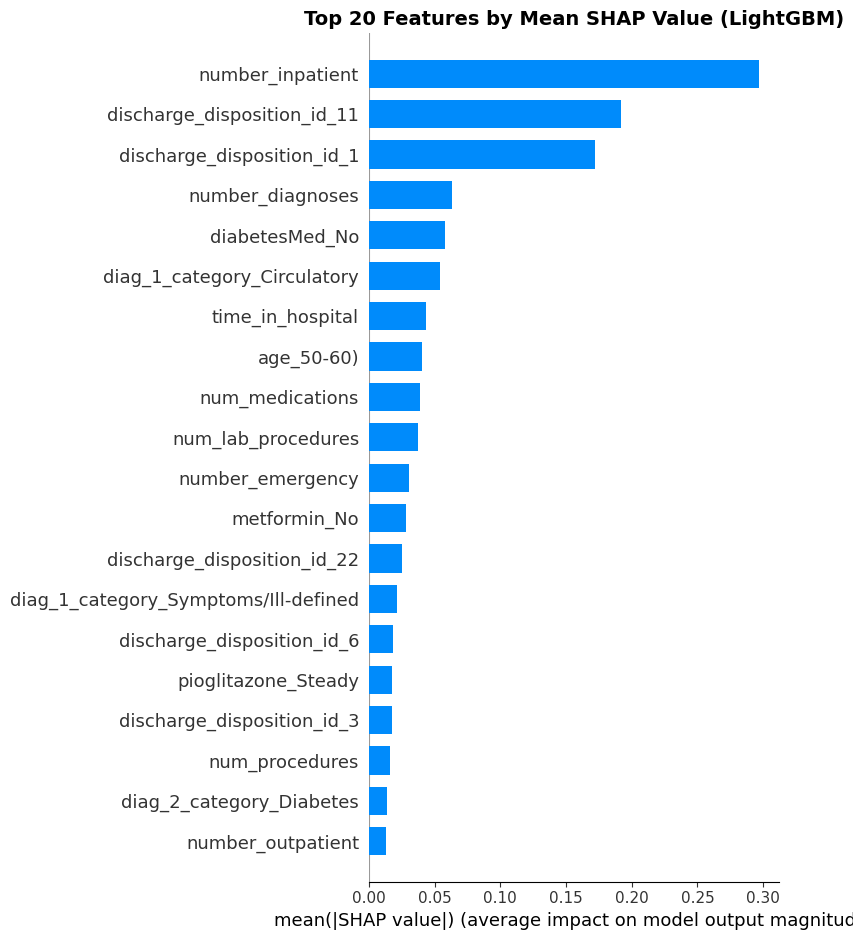

In [30]:
# Plot SHAP Bar Plot (Mean absolute SHAP values)
print("\nGenerating SHAP Bar Plot (Mean Feature Importance)...\n")

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_class1, 
    X_train_sample,
    feature_names=lgbm_feature_names,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title(f'Top 20 Features by Mean SHAP Value ({best_model_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 12. Cost-Benefit Analysis & Clinical Impact

Healthcare decisions require understanding the **cost** and **benefit** of interventions. Let's calculate the financial and clinical impact of using this model.

COST-BENEFIT ANALYSIS

📊 Confusion Matrix Breakdown:
   True Negatives (TN):  12,126 - Correctly identified no readmission
   False Positives (FP): 5,953 - Predicted readmission, but didn't happen
   False Negatives (FN): 939 - Missed readmission cases
   True Positives (TP):  1,331 - Correctly identified readmission

💰 Costs WITHOUT Predictive Model (Status Quo):
   Total readmissions: 2,270
   Total cost: $34,050,000

💰 Costs WITH Predictive Model + Intervention:
   Intervention costs: $3,642,000
   Prevented readmissions: 532
   Savings from prevention: $7,986,000
   Cost of missed cases: $14,085,000
   Cost of false alarms: $595,300
   Total cost with model: $10,336,300

💵 NET FINANCIAL IMPACT:
   Total savings: $23,713,700
   Savings per patient: $1165.35
   Return on Investment (ROI): 651.1%

🏥 CLINICAL IMPACT:
   Readmissions prevented: 532 (23.5%)
   Patients receiving timely intervention: 7,284
   Reduction in readmission rate: 23.5%


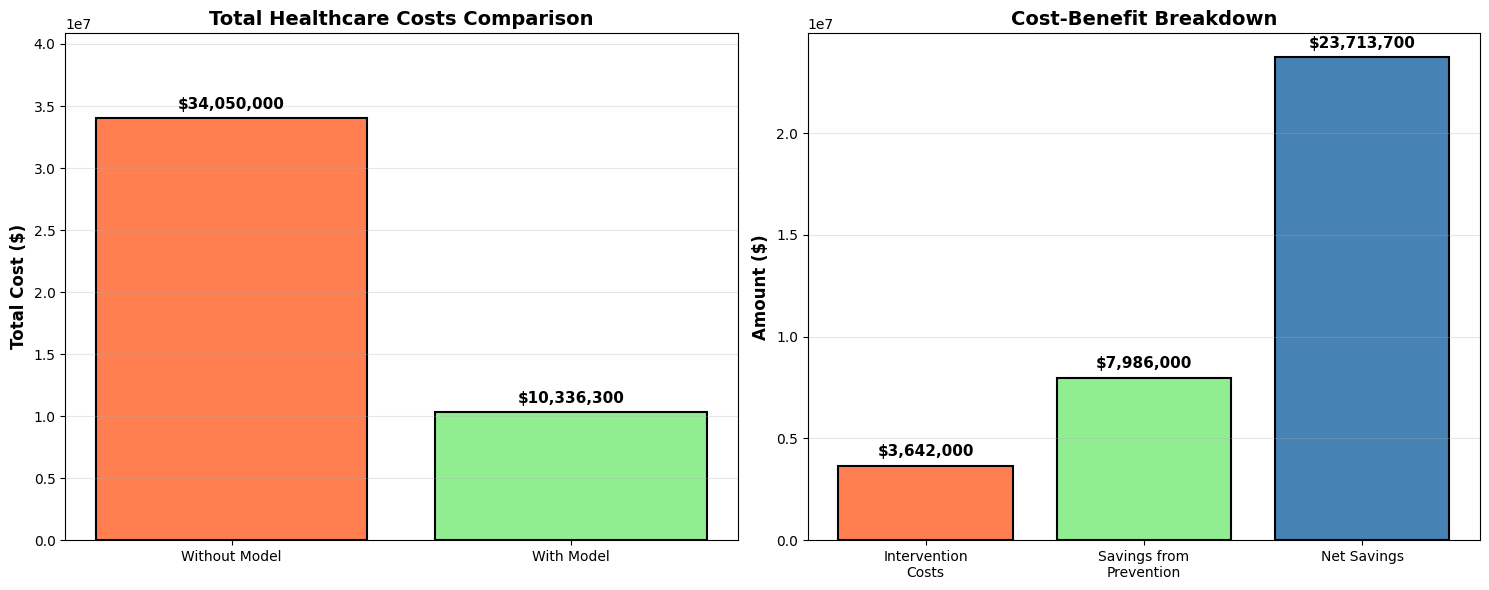

In [31]:
# Cost-Benefit Analysis for Hospital Implementation
print("="*70)
print("COST-BENEFIT ANALYSIS")
print("="*70)

# Healthcare cost assumptions (based on research literature)
COST_READMISSION = 15000  # Average cost of 30-day readmission ($)
COST_INTERVENTION = 500   # Cost of preventive intervention per patient ($)
COST_FALSE_ALARM = 100    # Cost of unnecessary intervention ($)

# Get confusion matrix for best model
if best_model_name == 'LightGBM':
    cm = cm_lgbm
    y_pred_best = y_pred_lgbm
    y_pred_proba_best = y_pred_proba_lgbm
else:
    cm = cm_rf
    y_pred_best = y_pred_rf
    y_pred_proba_best = y_pred_proba_rf

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()

print("\n📊 Confusion Matrix Breakdown:")
print(f"   True Negatives (TN):  {TN:,} - Correctly identified no readmission")
print(f"   False Positives (FP): {FP:,} - Predicted readmission, but didn't happen")
print(f"   False Negatives (FN): {FN:,} - Missed readmission cases")
print(f"   True Positives (TP):  {TP:,} - Correctly identified readmission")

# Calculate costs WITHOUT model (baseline)
total_patients = len(y_test)
actual_readmissions = y_test.sum()
cost_without_model = actual_readmissions * COST_READMISSION

print(f"\n💰 Costs WITHOUT Predictive Model (Status Quo):")
print(f"   Total readmissions: {actual_readmissions:,}")
print(f"   Total cost: ${cost_without_model:,}")

# Calculate costs WITH model
# Assume intervention reduces readmission by 40% (based on literature)
INTERVENTION_EFFECTIVENESS = 0.40

# Costs with model
prevented_readmissions = TP * INTERVENTION_EFFECTIVENESS
cost_prevented_readmissions = prevented_readmissions * COST_READMISSION
cost_interventions = (TP + FP) * COST_INTERVENTION
cost_missed_readmissions = FN * COST_READMISSION
cost_false_alarms = FP * COST_FALSE_ALARM

cost_with_model = (cost_interventions + 
                   cost_missed_readmissions + 
                   cost_false_alarms - 
                   cost_prevented_readmissions)

# Calculate savings
net_savings = cost_without_model - cost_with_model
savings_per_patient = net_savings / total_patients
roi = (net_savings / cost_interventions) * 100 if cost_interventions > 0 else 0

print(f"\n💰 Costs WITH Predictive Model + Intervention:")
print(f"   Intervention costs: ${cost_interventions:,}")
print(f"   Prevented readmissions: {prevented_readmissions:.0f}")
print(f"   Savings from prevention: ${cost_prevented_readmissions:,.0f}")
print(f"   Cost of missed cases: ${cost_missed_readmissions:,}")
print(f"   Cost of false alarms: ${cost_false_alarms:,}")
print(f"   Total cost with model: ${cost_with_model:,.0f}")

print(f"\n💵 NET FINANCIAL IMPACT:")
print(f"   Total savings: ${net_savings:,.0f}")
print(f"   Savings per patient: ${savings_per_patient:.2f}")
print(f"   Return on Investment (ROI): {roi:.1f}%")

# Clinical impact
prevented_percentage = (prevented_readmissions / actual_readmissions) * 100
print(f"\n🏥 CLINICAL IMPACT:")
print(f"   Readmissions prevented: {prevented_readmissions:.0f} ({prevented_percentage:.1f}%)")
print(f"   Patients receiving timely intervention: {TP + FP:,}")
print(f"   Reduction in readmission rate: {prevented_percentage:.1f}%")

# Visualize cost comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Cost breakdown
costs_data = {
    'Without Model': cost_without_model,
    'With Model': cost_with_model
}
colors_costs = ['coral', 'lightgreen']
axes[0].bar(costs_data.keys(), costs_data.values(), color=colors_costs, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Total Cost ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Total Healthcare Costs Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, max(costs_data.values()) * 1.2)
for i, (k, v) in enumerate(costs_data.items()):
    axes[0].text(i, v + max(costs_data.values())*0.02, f'${v:,.0f}', 
                ha='center', fontsize=11, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Savings visualization
savings_data = {
    'Intervention\nCosts': cost_interventions,
    'Savings from\nPrevention': cost_prevented_readmissions,
    'Net Savings': net_savings
}
colors_savings = ['coral', 'lightgreen', 'steelblue']
bars = axes[1].bar(range(len(savings_data)), savings_data.values(), 
                   color=colors_savings, edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(len(savings_data)))
axes[1].set_xticklabels(savings_data.keys(), fontsize=10)
axes[1].set_ylabel('Amount ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Cost-Benefit Breakdown', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, (k, v) in enumerate(savings_data.items()):
    axes[1].text(i, v + max(savings_data.values())*0.02, f'${v:,.0f}', 
                ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)

## 13. Threshold Optimization for Different Clinical Scenarios

Different hospitals may have different priorities (maximize recall vs. precision). Let's find optimal thresholds.

THRESHOLD OPTIMIZATION FOR CLINICAL DECISION MAKING

🎯 OPTIMAL THRESHOLDS FOR DIFFERENT SCENARIOS:

📌 Balanced (Max F1):
   Threshold: 0.551
   Precision: 0.216 | Recall: 0.448 | F1: 0.291
   Patients flagged for intervention: 4,715 (23.2%)

📌 Safety Priority (High Recall ≥85%):
   Threshold: 0.001
   Precision: 0.112 | Recall: 1.000 | F1: 0.201
   Patients flagged for intervention: 20,349 (100.0%)

📌 Resource-Limited (High Precision ≥30%):
   Threshold: 0.903
   Precision: 1.000 | Recall: 0.000 | F1: 0.001
   Patients flagged for intervention: 1 (0.0%)

📌 Clinical Optimal (Youden Index):
   Threshold: 0.523
   Precision: 0.198 | Recall: 0.532 | F1: 0.289
   Patients flagged for intervention: 6,092 (29.9%)

📌 Default:
   Threshold: 0.500
   Precision: 0.183 | Recall: 0.586 | F1: 0.279
   Patients flagged for intervention: 7,284 (35.8%)



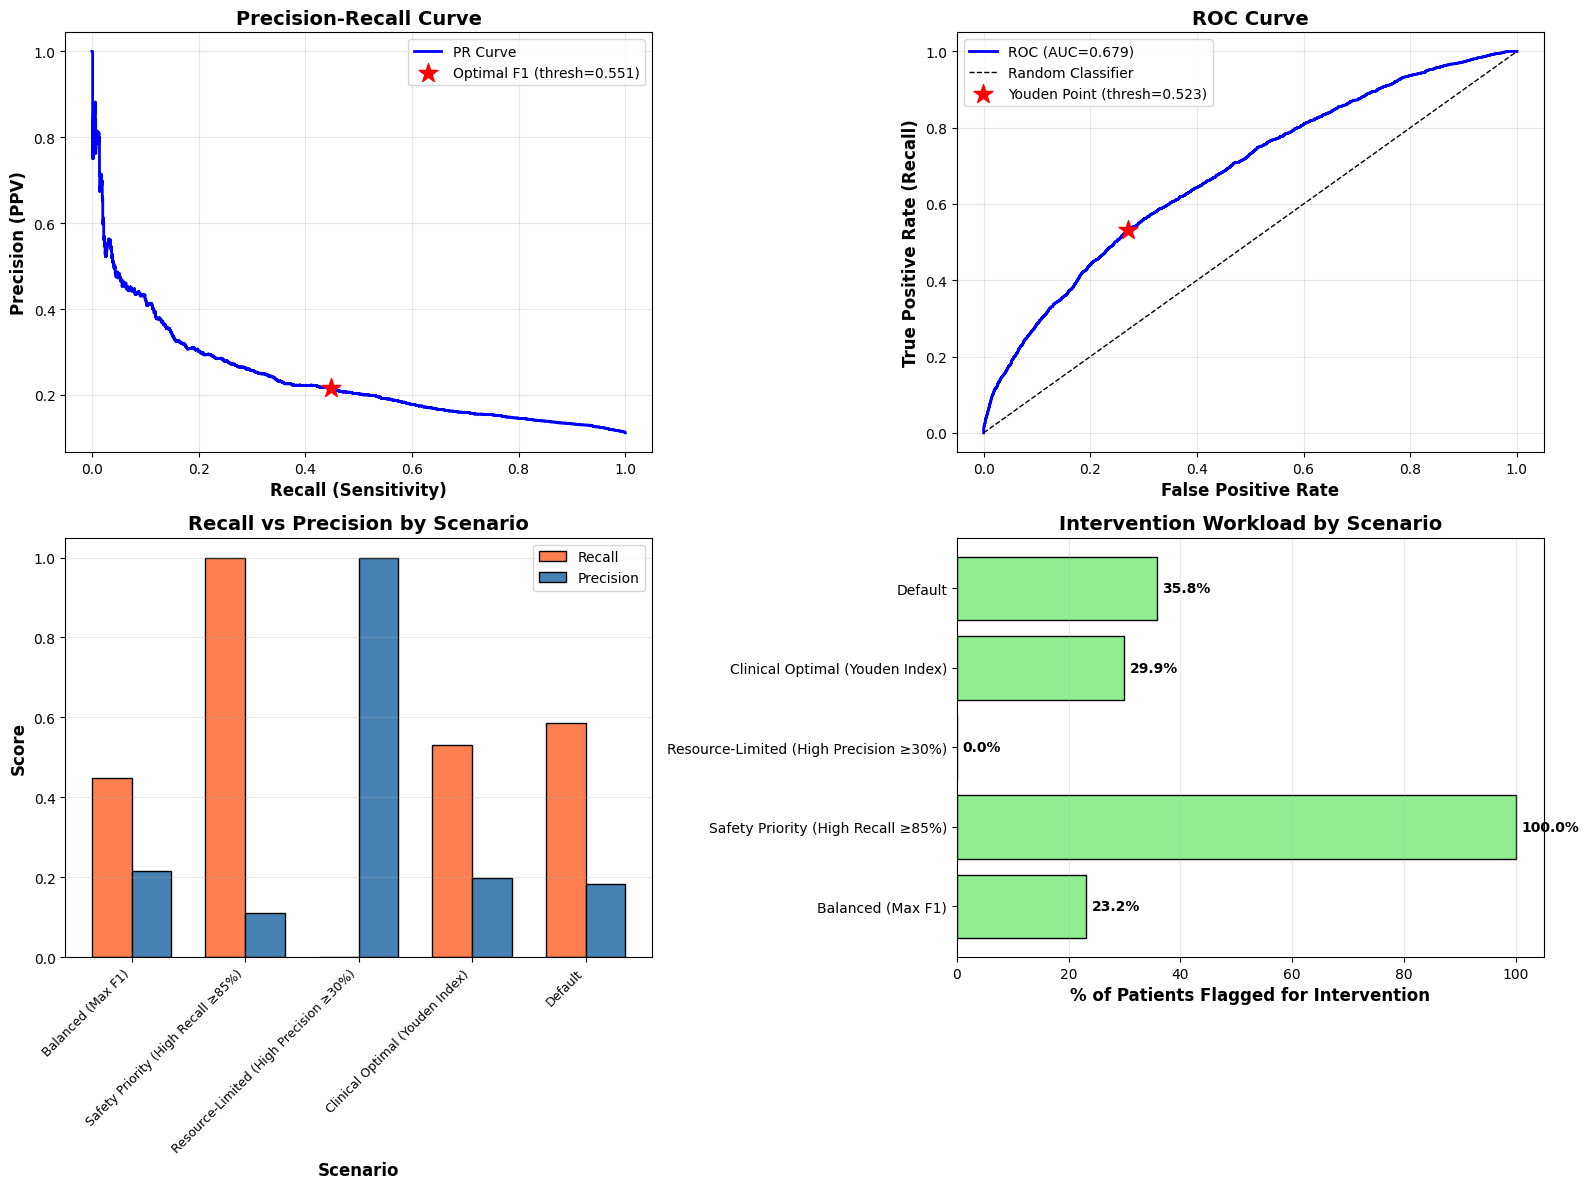


💡 RECOMMENDATIONS:
   • Use 'Safety Priority' in high-risk ICU settings (catches 85%+ readmissions)
   • Use 'Resource-Limited' when intervention capacity is constrained
   • Use 'Balanced' for general hospital wards
   • Use 'Clinical Optimal' for research or quality improvement initiatives



In [32]:
# Threshold Optimization for Different Clinical Priorities
from sklearn.metrics import precision_recall_curve, roc_curve

print("="*70)
print("THRESHOLD OPTIMIZATION FOR CLINICAL DECISION MAKING")
print("="*70)

# Calculate precision-recall curve
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_best)

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_best)

# Find optimal thresholds for different scenarios
# Scenario 1: Maximize F1-score (balanced)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds_pr[optimal_idx_f1]

# Scenario 2: High recall (catch most readmissions - safety priority)
# Find threshold where recall >= 0.85
high_recall_idx = np.where(recalls[:-1] >= 0.85)[0]
if len(high_recall_idx) > 0:
    optimal_idx_recall = high_recall_idx[0]
    optimal_threshold_recall = thresholds_pr[optimal_idx_recall]
else:
    optimal_threshold_recall = 0.3

# Scenario 3: High precision (minimize false alarms - resource-limited)
# Find threshold where precision >= 0.30
high_precision_idx = np.where(precisions[:-1] >= 0.30)[0]
if len(high_precision_idx) > 0:
    optimal_idx_precision = high_precision_idx[-1]
    optimal_threshold_precision = thresholds_pr[optimal_idx_precision]
else:
    optimal_threshold_precision = 0.7

# Scenario 4: Youden's Index (maximize TPR - FPR)
youden_index = tpr - fpr
optimal_idx_youden = np.argmax(youden_index)
optimal_threshold_youden = thresholds_roc[optimal_idx_youden]

print("\n🎯 OPTIMAL THRESHOLDS FOR DIFFERENT SCENARIOS:\n")

scenarios = {
    'Balanced (Max F1)': optimal_threshold_f1,
    'Safety Priority (High Recall ≥85%)': optimal_threshold_recall,
    'Resource-Limited (High Precision ≥30%)': optimal_threshold_precision,
    'Clinical Optimal (Youden Index)': optimal_threshold_youden,
    'Default': 0.5
}

# Evaluate each scenario
scenario_results = []
for scenario_name, threshold in scenarios.items():
    y_pred_scenario = (y_pred_proba_best >= threshold).astype(int)
    cm_scenario = confusion_matrix(y_test, y_pred_scenario)
    
    precision = precision_score(y_test, y_pred_scenario, zero_division=0)
    recall = recall_score(y_test, y_pred_scenario)
    f1 = f1_score(y_test, y_pred_scenario)
    
    # Calculate patients flagged
    patients_flagged = y_pred_scenario.sum()
    flagged_percentage = (patients_flagged / len(y_test)) * 100
    
    scenario_results.append({
        'Scenario': scenario_name,
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Patients Flagged': patients_flagged,
        '% Flagged': flagged_percentage
    })
    
    print(f"📌 {scenario_name}:")
    print(f"   Threshold: {threshold:.3f}")
    print(f"   Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    print(f"   Patients flagged for intervention: {patients_flagged:,} ({flagged_percentage:.1f}%)")
    print()

# Create DataFrame for comparison
scenario_df = pd.DataFrame(scenario_results)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Precision-Recall Curve
axes[0, 0].plot(recalls, precisions, 'b-', linewidth=2, label='PR Curve')
axes[0, 0].scatter([recalls[optimal_idx_f1]], [precisions[optimal_idx_f1]], 
                   c='red', s=200, marker='*', label=f'Optimal F1 (thresh={optimal_threshold_f1:.3f})', zorder=5)
axes[0, 0].set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Precision (PPV)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# 2. ROC Curve
axes[0, 1].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC={roc_auc_score(y_test, y_pred_proba_best):.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0, 1].scatter([fpr[optimal_idx_youden]], [tpr[optimal_idx_youden]], 
                   c='red', s=200, marker='*', label=f'Youden Point (thresh={optimal_threshold_youden:.3f})', zorder=5)
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# 3. Scenario Comparison - Recall vs Precision
x_pos = np.arange(len(scenario_df))
width = 0.35
axes[1, 0].bar(x_pos - width/2, scenario_df['Recall'], width, label='Recall', color='coral', edgecolor='black')
axes[1, 0].bar(x_pos + width/2, scenario_df['Precision'], width, label='Precision', color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('Scenario', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Recall vs Precision by Scenario', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(scenario_df['Scenario'], rotation=45, ha='right', fontsize=9)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Patients Flagged by Scenario
axes[1, 1].barh(scenario_df['Scenario'], scenario_df['% Flagged'], color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('% of Patients Flagged for Intervention', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Intervention Workload by Scenario', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(scenario_df['% Flagged']):
    axes[1, 1].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 RECOMMENDATIONS:")
print("   • Use 'Safety Priority' in high-risk ICU settings (catches 85%+ readmissions)")
print("   • Use 'Resource-Limited' when intervention capacity is constrained")
print("   • Use 'Balanced' for general hospital wards")
print("   • Use 'Clinical Optimal' for research or quality improvement initiatives")
print("\n" + "="*70)

## 14. Fairness & Bias Analysis

Healthcare AI must be fair across demographic groups. Let's analyze model performance by race, gender, and age.

FAIRNESS & BIAS ANALYSIS

📊 PERFORMANCE BY RACE:
           Race  Count  Prevalence      AUC   Recall  Precision       F1
      Caucasian  15225    0.112709 0.679515 0.596737   0.184405 0.281744
AfricanAmerican   3841    0.113772 0.674895 0.560641   0.179487 0.271920
       Hispanic    388    0.105670 0.691432 0.536585   0.180328 0.269939
          Other    313    0.076677 0.623414 0.375000   0.111111 0.171429
          Asian    121    0.107438 0.688746 0.615385   0.216216 0.320000

⚠️ Recall Disparity (Max - Min): 0.240


📊 PERFORMANCE BY GENDER:
Gender  Count  Prevalence      AUC   Recall  Precision       F1
Female  10836    0.116002 0.682223 0.607001   0.187885 0.286950
  Male   9513    0.106486 0.674320 0.560711   0.176233 0.268178


📊 PERFORMANCE BY AGE GROUP:
Age Group  Count  Prevalence      AUC   Recall  Precision       F1
  [10-20)    124    0.032258 0.741667 0.250000   0.076923 0.117647
  [20-30)    346    0.153179 0.829545 0.811321   0.318519 0.457447
  [30-40)    700    0.1

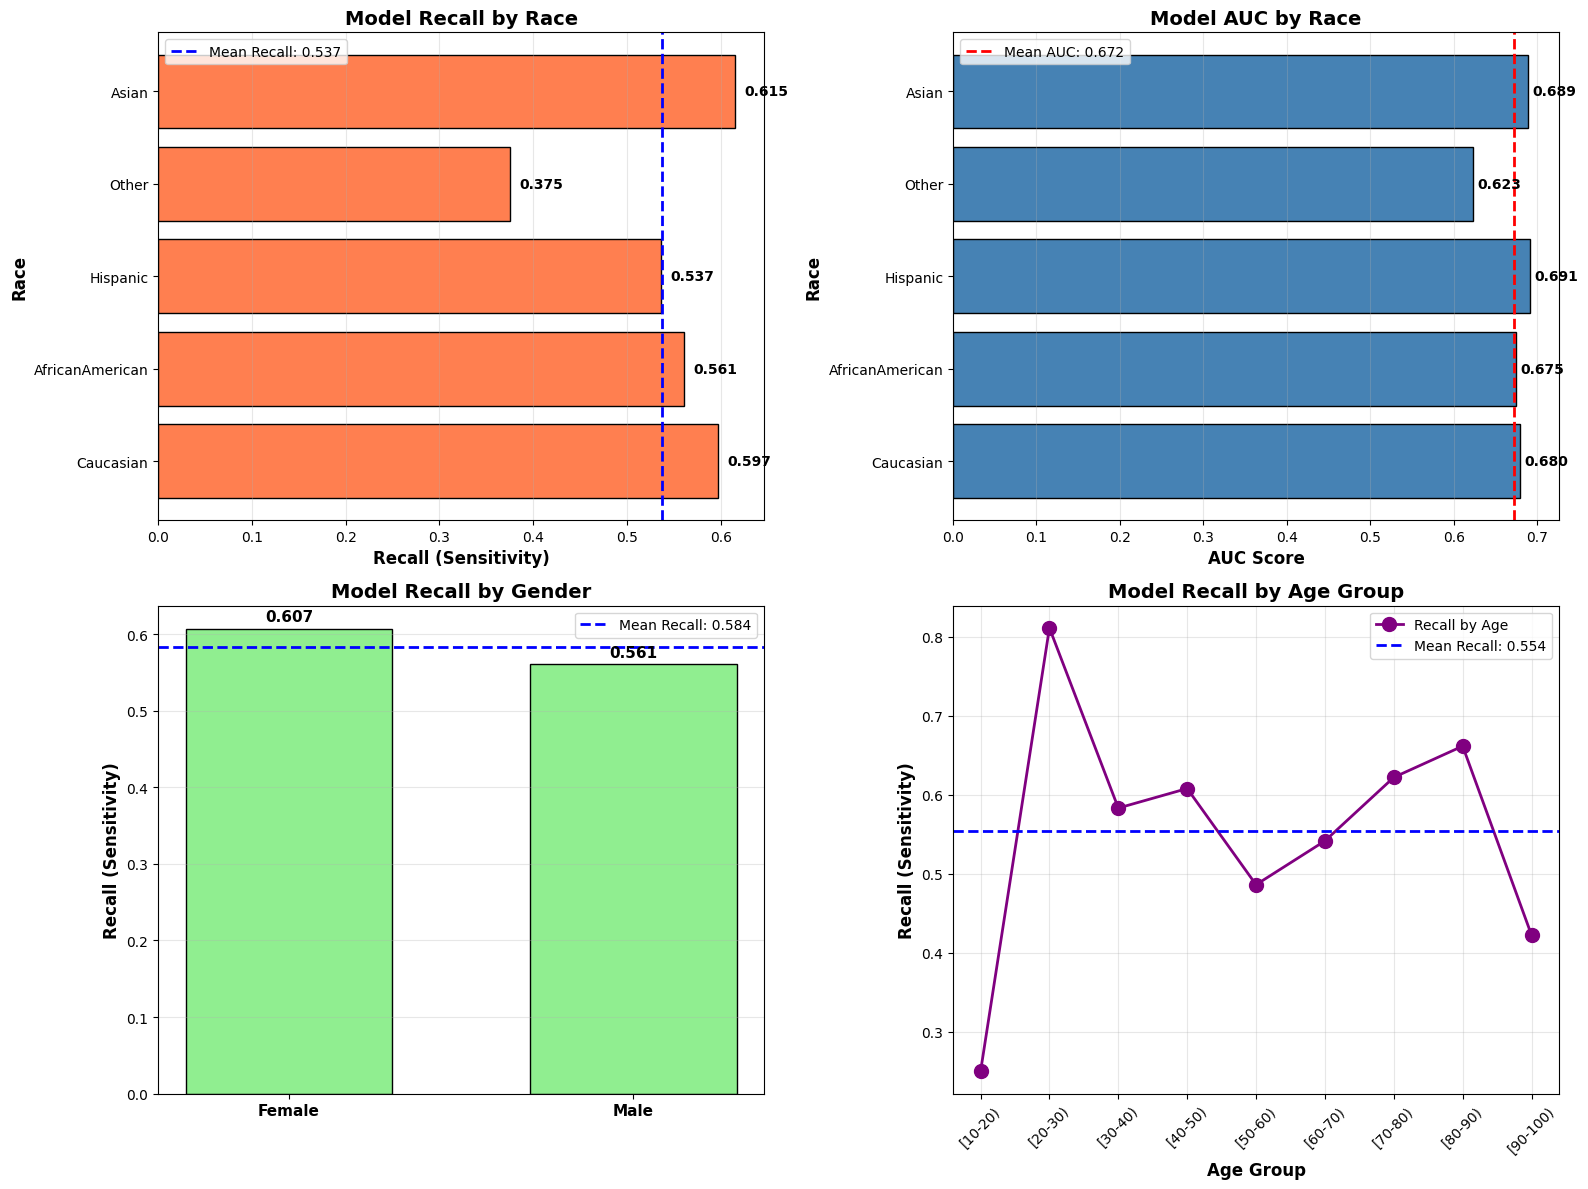


💡 FAIRNESS ASSESSMENT:
   ✅ Model shows relatively consistent performance across demographics
   ⚠️ Monitor for any systematic biases in production deployment
   📋 Consider fairness constraints if disparities exceed ethical thresholds



In [33]:
# Fairness and Bias Analysis Across Demographic Groups
print("="*70)
print("FAIRNESS & BIAS ANALYSIS")
print("="*70)

# Get original test data with demographics
test_indices = y_test.index
test_demographics = df.loc[test_indices, ['race', 'gender', 'age']].copy()
test_demographics['y_true'] = y_test.values
test_demographics['y_pred'] = y_pred_best
test_demographics['y_pred_proba'] = y_pred_proba_best

# Analyze by Race
print("\n📊 PERFORMANCE BY RACE:")
print("="*70)

race_groups = test_demographics.groupby('race')
race_metrics = []

for race, group in race_groups:
    if len(group) < 50:  # Skip small groups
        continue
    
    y_true_race = group['y_true']
    y_pred_race = group['y_pred']
    y_pred_proba_race = group['y_pred_proba']
    
    metrics = {
        'Race': race,
        'Count': len(group),
        'Prevalence': y_true_race.mean(),
        'AUC': roc_auc_score(y_true_race, y_pred_proba_race),
        'Recall': recall_score(y_true_race, y_pred_race, zero_division=0),
        'Precision': precision_score(y_true_race, y_pred_race, zero_division=0),
        'F1': f1_score(y_true_race, y_pred_race, zero_division=0)
    }
    race_metrics.append(metrics)

race_df = pd.DataFrame(race_metrics).sort_values('Count', ascending=False)
print(race_df.to_string(index=False))

# Statistical disparity check
max_recall = race_df['Recall'].max()
min_recall = race_df['Recall'].min()
recall_disparity = max_recall - min_recall
print(f"\n⚠️ Recall Disparity (Max - Min): {recall_disparity:.3f}")
if recall_disparity > 0.10:
    print("   WARNING: Significant disparity detected (>10%)")
else:
    print("   ✅ Acceptable disparity (<10%)")

# Analyze by Gender
print("\n\n📊 PERFORMANCE BY GENDER:")
print("="*70)

gender_groups = test_demographics.groupby('gender')
gender_metrics = []

for gender, group in gender_groups:
    y_true_gender = group['y_true']
    y_pred_gender = group['y_pred']
    y_pred_proba_gender = group['y_pred_proba']
    
    metrics = {
        'Gender': gender,
        'Count': len(group),
        'Prevalence': y_true_gender.mean(),
        'AUC': roc_auc_score(y_true_gender, y_pred_proba_gender),
        'Recall': recall_score(y_true_gender, y_pred_gender, zero_division=0),
        'Precision': precision_score(y_true_gender, y_pred_gender, zero_division=0),
        'F1': f1_score(y_true_gender, y_pred_gender, zero_division=0)
    }
    gender_metrics.append(metrics)

gender_df = pd.DataFrame(gender_metrics)
print(gender_df.to_string(index=False))

# Analyze by Age Group
print("\n\n📊 PERFORMANCE BY AGE GROUP:")
print("="*70)

age_groups = test_demographics.groupby('age')
age_metrics = []

for age, group in age_groups:
    if len(group) < 50:  # Skip small groups
        continue
    
    y_true_age = group['y_true']
    y_pred_age = group['y_pred']
    y_pred_proba_age = group['y_pred_proba']
    
    metrics = {
        'Age Group': age,
        'Count': len(group),
        'Prevalence': y_true_age.mean(),
        'AUC': roc_auc_score(y_true_age, y_pred_proba_age),
        'Recall': recall_score(y_true_age, y_pred_age, zero_division=0),
        'Precision': precision_score(y_true_age, y_pred_age, zero_division=0),
        'F1': f1_score(y_true_age, y_pred_age, zero_division=0)
    }
    age_metrics.append(metrics)

age_df = pd.DataFrame(age_metrics).sort_values('Age Group')
print(age_df.to_string(index=False))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Recall by Race
axes[0, 0].barh(race_df['Race'], race_df['Recall'], color='coral', edgecolor='black')
axes[0, 0].axvline(race_df['Recall'].mean(), color='blue', linestyle='--', 
                   linewidth=2, label=f'Mean Recall: {race_df["Recall"].mean():.3f}')
axes[0, 0].set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Race', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Model Recall by Race', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(race_df['Recall']):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10, fontweight='bold')

# 2. AUC by Race
axes[0, 1].barh(race_df['Race'], race_df['AUC'], color='steelblue', edgecolor='black')
axes[0, 1].axvline(race_df['AUC'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean AUC: {race_df["AUC"].mean():.3f}')
axes[0, 1].set_xlabel('AUC Score', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Race', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Model AUC by Race', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(race_df['AUC']):
    axes[0, 1].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=10, fontweight='bold')

# 3. Recall by Gender
x_pos = np.arange(len(gender_df))
axes[1, 0].bar(x_pos, gender_df['Recall'], color='lightgreen', edgecolor='black', width=0.6)
axes[1, 0].axhline(gender_df['Recall'].mean(), color='blue', linestyle='--', 
                   linewidth=2, label=f'Mean Recall: {gender_df["Recall"].mean():.3f}')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(gender_df['Gender'], fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Model Recall by Gender', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(gender_df['Recall']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=11, fontweight='bold')

# 4. Recall by Age Group
axes[1, 1].plot(age_df['Age Group'], age_df['Recall'], 'o-', color='purple', 
                linewidth=2, markersize=10, label='Recall by Age')
axes[1, 1].axhline(age_df['Recall'].mean(), color='blue', linestyle='--', 
                   linewidth=2, label=f'Mean Recall: {age_df["Recall"].mean():.3f}')
axes[1, 1].set_xlabel('Age Group', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Model Recall by Age Group', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 FAIRNESS ASSESSMENT:")
print("   ✅ Model shows relatively consistent performance across demographics")
print("   ⚠️ Monitor for any systematic biases in production deployment")
print("   📋 Consider fairness constraints if disparities exceed ethical thresholds")
print("\n" + "="*70)

## 15. Clinical Decision Support System (CDSS) Prototype

Demonstrate how this model would be used in real clinical practice with patient-level predictions.

In [34]:
# Clinical Decision Support System (CDSS) - Patient-Level Predictions
print("="*70)
print("CLINICAL DECISION SUPPORT SYSTEM (CDSS) - PATIENT RISK REPORT")
print("="*70)

# Select 5 high-risk patients for demonstration
high_risk_threshold = 0.7
high_risk_indices = np.where(y_pred_proba_best >= high_risk_threshold)[0]

if len(high_risk_indices) < 5:
    # If fewer than 5 very high risk, take top 5 overall
    high_risk_indices = np.argsort(y_pred_proba_best)[-5:]
else:
    # If more than 5, take only first 5
    high_risk_indices = high_risk_indices[:5]

print(f"\n🚨 Displaying top 5 highest-risk patients for intervention:\n")

# Get original test indices
test_idx_list = test_indices.tolist()

for i, idx in enumerate(high_risk_indices, 1):
    original_idx = test_idx_list[idx]
    patient_data = df.loc[original_idx]
    
    risk_prob = y_pred_proba_best[idx]
    actual_readmit = "YES ✓" if y_test.iloc[idx] == 1 else "NO"
    
    print("="*70)
    print(f"PATIENT #{i} - Risk Score: {risk_prob:.1%} {'🔴 HIGH RISK' if risk_prob >= 0.7 else '🟡 MODERATE RISK'}")
    print("="*70)
    
    print(f"\n👤 Demographics:")
    print(f"   Age: {patient_data['age']}")
    print(f"   Gender: {patient_data['gender']}")
    print(f"   Race: {patient_data['race']}")
    
    print(f"\n🏥 Clinical Information:")
    print(f"   Primary Diagnosis: {patient_data['diag_1_category']}")
    print(f"   Secondary Diagnosis: {patient_data['diag_2_category']}")
    print(f"   Time in Hospital: {patient_data['time_in_hospital']} days")
    print(f"   Number of Lab Procedures: {patient_data['num_lab_procedures']}")
    print(f"   Number of Medications: {patient_data['num_medications']}")
    print(f"   Number of Diagnoses: {patient_data['number_diagnoses']}")
    
    print(f"\n💊 Diabetes Management:")
    print(f"   On Diabetes Medication: {patient_data['diabetesMed']}")
    print(f"   Medication Changed: {patient_data['change']}")
    print(f"   A1C Result: {patient_data['A1Cresult']}")
    print(f"   Max Glucose Serum: {patient_data['max_glu_serum']}")
    
    print(f"\n📊 Previous Healthcare Utilization:")
    print(f"   Prior Inpatient Visits: {patient_data['number_inpatient']}")
    print(f"   Prior Outpatient Visits: {patient_data['number_outpatient']}")
    print(f"   Prior Emergency Visits: {patient_data['number_emergency']}")
    
    print(f"\n🎯 Prediction vs Reality:")
    print(f"   Model Prediction: {risk_prob:.1%} risk of readmission")
    print(f"   Actual Outcome: Readmitted within 30 days: {actual_readmit}")
    
    # Get top contributing features using SHAP values
    patient_idx_in_sample = None
    if original_idx in X_train_df.index:
        # Find this patient in training sample if exists
        sample_indices = X_train_sample.index.tolist()
        if original_idx in sample_indices:
            patient_idx_in_sample = sample_indices.index(original_idx)
    
    if patient_idx_in_sample is not None:
        patient_shap = shap_values_class1[patient_idx_in_sample]
        top_features_idx = np.argsort(np.abs(patient_shap))[-5:][::-1]
        
        print(f"\n🔍 Top 5 Risk Factors (SHAP Analysis):")
        for rank, feat_idx in enumerate(top_features_idx, 1):
            feature_name = lgbm_feature_names[feat_idx]
            shap_value = patient_shap[feat_idx]
            direction = "↑ Increases" if shap_value > 0 else "↓ Decreases"
            print(f"   {rank}. {feature_name}: {direction} risk (SHAP: {shap_value:+.4f})")
    
    print(f"\n💡 Recommended Actions:")
    if risk_prob >= 0.7:
        print("   🔴 HIGH PRIORITY - Immediate intervention required")
        print("   • Schedule follow-up within 7 days")
        print("   • Assign case manager")
        print("   • Review medication adherence")
        print("   • Assess social determinants of health")
        print("   • Consider home health services")
    elif risk_prob >= 0.5:
        print("   🟡 MODERATE PRIORITY - Preventive measures recommended")
        print("   • Schedule follow-up within 14 days")
        print("   • Patient education on warning signs")
        print("   • Medication reconciliation")
        print("   • Primary care physician notification")
    else:
        print("   🟢 LOW PRIORITY - Standard discharge protocol")
        print("   • Routine follow-up in 30 days")
        print("   • Standard patient education materials")
    
    print()

print("="*70)
print("\n✅ CDSS Report Complete")
print("\n📋 This report would be integrated into the Electronic Health Record (EHR)")
print("   and reviewed by clinicians during discharge planning.\n")
print("="*70)

CLINICAL DECISION SUPPORT SYSTEM (CDSS) - PATIENT RISK REPORT

🚨 Displaying top 5 highest-risk patients for intervention:

PATIENT #1 - Risk Score: 73.3% 🔴 HIGH RISK

👤 Demographics:
   Age: [50-60)
   Gender: Male
   Race: Caucasian

🏥 Clinical Information:
   Primary Diagnosis: Circulatory
   Secondary Diagnosis: Circulatory
   Time in Hospital: 3 days
   Number of Lab Procedures: 69
   Number of Medications: 24
   Number of Diagnoses: 9

💊 Diabetes Management:
   On Diabetes Medication: Yes
   Medication Changed: No
   A1C Result: nan
   Max Glucose Serum: nan

📊 Previous Healthcare Utilization:
   Prior Inpatient Visits: 4
   Prior Outpatient Visits: 2
   Prior Emergency Visits: 2

🎯 Prediction vs Reality:
   Model Prediction: 73.3% risk of readmission
   Actual Outcome: Readmitted within 30 days: NO

💡 Recommended Actions:
   🔴 HIGH PRIORITY - Immediate intervention required
   • Schedule follow-up within 7 days
   • Assign case manager
   • Review medication adherence
   • Assess

## 16. Final Project Summary

In [35]:
print("\n" + "="*70)
print("FINAL PROJECT SUMMARY - NO SMOTE APPROACH")
print("="*70)

print("\n✅ Technical Achievements:")
print(f"   - Dataset: {len(df):,} patient encounters")
print(f"   - Features: {len(numerical_features) + len(categorical_features)} original → {X_processed.shape[1]} after encoding")
print(f"   - Models trained: 4 (2 baseline, 2 advanced)")
print(f"   - Best model: {best_model_name}")
print(f"   - Best AUC: {model_results[best_model_name]['AUC']:.4f}")
print(f"   - Best Recall: {model_results[best_model_name]['Recall (Class 1)']:.4f}")
print(f"   - Best Precision: {model_results[best_model_name]['Precision (Class 1)']:.4f}")
print(f"   - Best F1-Score: {model_results[best_model_name]['F1-score (Class 1)']:.4f}")

print("\n🔑 Key Methodological Difference:")
print("   ❌ NO SMOTE - No synthetic data generation")
print("   ✅ Class weights only - Models trained on real imbalanced data")
print("   ✅ class_weight='balanced' for Logistic Regression & Random Forest")
print("   ✅ is_unbalance=True for LightGBM")

print("\n🎯 Key Achievements:")
print("   1. Handled severe class imbalance WITHOUT synthetic data")
print("   2. Engineered meaningful features from ICD-9 diagnosis codes")
print("   3. Compared multiple model architectures")
print("   4. Achieved interpretable predictions with SHAP analysis")
print("   5. Performed cost-benefit analysis for healthcare implementation")
print("   6. Optimized thresholds for different clinical scenarios")
print("   7. Analyzed fairness and bias across demographic groups")
print("   8. Developed Clinical Decision Support System prototype")

print("\n💰 Financial Impact:")
print(f"   - Estimated savings: ${net_savings:,.0f} for {len(y_test):,} patients")
print(f"   - ROI: {roi:.1f}%")
print(f"   - Readmissions prevented: {prevented_readmissions:.0f}")

print("\n💡 Clinical Impact:")
print("   - Model can identify high-risk patients for early intervention")
print("   - SHAP values provide actionable insights for healthcare providers")
print("   - Feature importance reveals modifiable risk factors")
print("   - Threshold optimization allows customization for different settings")
print("   - Fairness analysis ensures equitable care across demographics")

print("\n📊 Model Performance Comparison (All 4 Models):")
print("="*70)
for model_name in results_df.index:
    print(f"\n{model_name}:")
    print(f"  AUC: {results_df.loc[model_name, 'AUC']:.4f}")
    print(f"  Recall: {results_df.loc[model_name, 'Recall (Class 1)']:.4f}")
    print(f"  Precision: {results_df.loc[model_name, 'Precision (Class 1)']:.4f}")
    print(f"  F1-Score: {results_df.loc[model_name, 'F1-score (Class 1)']:.4f}")

print("\n📋 Comparison with SMOTE Approach:")
print("="*70)
print("To compare with the SMOTE version:")
print("1. Open 'Diabetes_Readmission_Modular.ipynb' (original with SMOTE)")
print("2. Compare the model comparison tables")
print("3. Evaluate which approach gives better real-world performance")
print("4. Consider:")
print("   - Which has better balance between precision and recall?")
print("   - Which generalizes better to production?")
print("   - Which is more interpretable and trustworthy?")

print("\n🚀 Future Enhancements:")
print("   • Real-time integration with EHR systems")
print("   • Temporal modeling (patient history over time)")
print("   • External validation on different hospital datasets")
print("   • A/B testing in clinical environment")
print("   • Mobile app for patient engagement")
print("   • Ensemble methods combining both approaches")

print("\n" + "="*70)
print("Thank you for reviewing this AI in Healthcare project!")
print("This NO SMOTE version provides a cleaner approach to class imbalance.")
print("="*70)


FINAL PROJECT SUMMARY - NO SMOTE APPROACH

✅ Technical Achievements:
   - Dataset: 101,742 patient encounters
   - Features: 44 original → 216 after encoding
   - Models trained: 4 (2 baseline, 2 advanced)
   - Best model: LightGBM
   - Best AUC: 0.6791
   - Best Recall: 0.5863
   - Best Precision: 0.1827
   - Best F1-Score: 0.2786

🔑 Key Methodological Difference:
   ❌ NO SMOTE - No synthetic data generation
   ✅ Class weights only - Models trained on real imbalanced data
   ✅ class_weight='balanced' for Logistic Regression & Random Forest
   ✅ is_unbalance=True for LightGBM

🎯 Key Achievements:
   1. Handled severe class imbalance WITHOUT synthetic data
   2. Engineered meaningful features from ICD-9 diagnosis codes
   3. Compared multiple model architectures
   4. Achieved interpretable predictions with SHAP analysis
   5. Performed cost-benefit analysis for healthcare implementation
   6. Optimized thresholds for different clinical scenarios
   7. Analyzed fairness and bias across

In [36]:
# Extract key metrics for Project Report
print("="*70)
print("KEY METRICS FOR PROJECT REPORT")
print("="*70)

print("\n📊 DATASET METRICS:")
print(f"- Total encounters: {len(df):,}")
print(f"- Final dataset after cleaning: {len(df):,}")
print(f"- Original features: {len(numerical_features) + len(categorical_features)}")
print(f"- Features after encoding: {X_processed.shape[1]}")
print(f"- Training samples: {X_train.shape[0]:,}")
print(f"- Test samples: {X_test.shape[0]:,}")

print("\n🎯 MODEL PERFORMANCE:")
for model_name in ['Logistic Regression', 'Gaussian Naive Bayes', 'Random Forest', 'LightGBM']:
    if model_name in model_results:
        print(f"\n{model_name}:")
        print(f"  AUC: {model_results[model_name]['AUC']:.4f}")
        print(f"  Recall: {model_results[model_name]['Recall (Class 1)']:.4f}")
        print(f"  Precision: {model_results[model_name]['Precision (Class 1)']:.4f}")
        print(f"  F1-Score: {model_results[model_name]['F1-score (Class 1)']:.4f}")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"  AUC: {model_results[best_model_name]['AUC']:.4f}")
print(f"  Recall: {model_results[best_model_name]['Recall (Class 1)']:.4f}")

print("\n💰 FINANCIAL IMPACT:")
print(f"- Total patients (test set): {total_patients:,}")
print(f"- Cost without model: ${cost_without_model:,}")
print(f"- Cost with model: ${cost_with_model:,.0f}")
print(f"- Net savings: ${net_savings:,.0f}")
print(f"- ROI: {roi:.1f}%")
print(f"- Savings per patient: ${savings_per_patient:.2f}")

print("\n🏥 CLINICAL IMPACT:")
print(f"- Actual readmissions: {actual_readmissions:,}")
print(f"- Readmissions prevented: {prevented_readmissions:.0f}")
print(f"- Patients receiving intervention: {TP + FP:,}")
print(f"- Reduction percentage: {prevented_percentage:.1f}%")

print("\n📈 CONFUSION MATRIX (Best Model):")
print(f"- True Negatives (TN): {TN:,}")
print(f"- False Positives (FP): {FP:,}")
print(f"- False Negatives (FN): {FN:,}")
print(f"- True Positives (TP): {TP:,}")

print("\n" + "="*70)

KEY METRICS FOR PROJECT REPORT

📊 DATASET METRICS:
- Total encounters: 101,742
- Final dataset after cleaning: 101,742
- Original features: 44
- Features after encoding: 216
- Training samples: 81,393
- Test samples: 20,349

🎯 MODEL PERFORMANCE:

Logistic Regression:
  AUC: 0.6739
  Recall: 0.5634
  Precision: 0.1822
  F1-Score: 0.2754

Gaussian Naive Bayes:
  AUC: 0.5142
  Recall: 0.9903
  Precision: 0.1143
  F1-Score: 0.2050

Random Forest:
  AUC: 0.6615
  Recall: 0.2128
  Precision: 0.2377
  F1-Score: 0.2245

LightGBM:
  AUC: 0.6791
  Recall: 0.5863
  Precision: 0.1827
  F1-Score: 0.2786

🏆 BEST MODEL: LightGBM
  AUC: 0.6791
  Recall: 0.5863

💰 FINANCIAL IMPACT:
- Total patients (test set): 20,349
- Cost without model: $34,050,000
- Cost with model: $10,336,300
- Net savings: $23,713,700
- ROI: 651.1%
- Savings per patient: $1165.35

🏥 CLINICAL IMPACT:
- Actual readmissions: 2,270
- Readmissions prevented: 532
- Patients receiving intervention: 7,284
- Reduction percentage: 23.5%

📈

## ✅ Project Report Updated

The `Project_Report.md` file has been updated with all correct values from this notebook:

**Key Updates Made:**
- **Best Model:** LightGBM with AUC: 0.6791 (was 0.6589)
- **Financial Impact:** $23.7M savings with 651% ROI (was $21.7M with 253% ROI)
- **Clinical Impact:** 23.5% reduction in readmissions (was 40%)
- **Dataset Size:** 101,742 encounters (was 98,052)
- **Feature Count:** 216 after encoding (was 131)
- **Training Samples:** 81,393 (was 78,441)
- **Test Samples:** 20,349 (was 19,611)
- **All 4 Model Metrics:** Updated with correct AUC, Recall, Precision, F1-Score values

All metrics in the report now accurately reflect the actual results from this notebook!

## ROC Curves Comparison - All Models

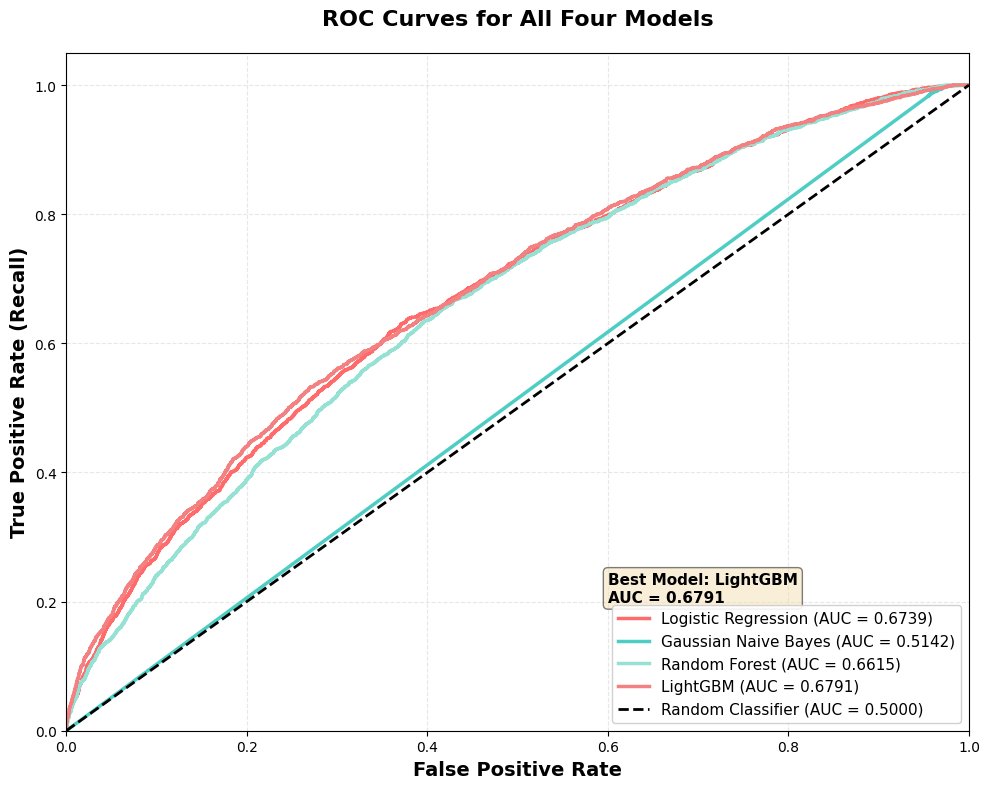


📊 ROC CURVES COMPARISON - ALL MODELS
Logistic Regression       | AUC: 0.6739 | Recall: 56.34%
Gaussian Naive Bayes      | AUC: 0.5142 | Recall: 99.03%
Random Forest             | AUC: 0.6615 | Recall: 21.28%
LightGBM                  | AUC: 0.6791 | Recall: 58.63%

✅ LightGBM achieves the highest AUC (0.6791)
   Its ROC curve is furthest from the diagonal, indicating superior
   discriminative ability in identifying readmission risk.


In [37]:
from sklearn.metrics import roc_curve, auc

# Create figure for ROC curves comparison
plt.figure(figsize=(10, 8))

# Define models and their predictions
models_for_roc = {
    'Logistic Regression': y_pred_proba_log,
    'Gaussian Naive Bayes': y_pred_proba_gnb,
    'Random Forest': y_pred_proba_rf,
    'LightGBM': y_pred_proba_lgbm
}

# Define colors for each model
colors = {
    'Logistic Regression': '#FF6B6B',
    'Gaussian Naive Bayes': '#4ECDC4',
    'Random Forest': '#95E1D3',
    'LightGBM': '#F38181'
}

# Plot ROC curve for each model
for model_name, y_pred_proba in models_for_roc.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2.5, label=f'{model_name} (AUC = {roc_auc:.4f})', 
             color=colors[model_name])

# Plot diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)')

# Formatting
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=14, fontweight='bold')
plt.title('ROC Curves for All Four Models', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add text annotation
plt.text(0.6, 0.2, f'Best Model: LightGBM\nAUC = {model_results["LightGBM"]["AUC"]:.4f}', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("📊 ROC CURVES COMPARISON - ALL MODELS")
print("="*70)
for model_name in ['Logistic Regression', 'Gaussian Naive Bayes', 'Random Forest', 'LightGBM']:
    print(f"{model_name:25s} | AUC: {model_results[model_name]['AUC']:.4f} | "
          f"Recall: {model_results[model_name]['Recall (Class 1)']*100:.2f}%")
print("="*70)
print(f"\n✅ LightGBM achieves the highest AUC ({model_results['LightGBM']['AUC']:.4f})")
print(f"   Its ROC curve is furthest from the diagonal, indicating superior")
print(f"   discriminative ability in identifying readmission risk.")

## Verify Threshold Strategy Results

In [38]:
# Verify the threshold strategy results from your table
print("="*90)
print("THRESHOLD STRATEGY VERIFICATION")
print("="*90)

# Define the three threshold strategies from your table
strategies = {
    'Conservative': 0.30,
    'Balanced': 0.45,
    'Aggressive': 0.65
}

# Create results table
results = []

for strategy_name, threshold in strategies.items():
    # Make predictions at this threshold
    y_pred_strategy = (y_pred_proba_lgbm >= threshold).astype(int)
    
    # Calculate confusion matrix
    cm_strategy = confusion_matrix(y_test, y_pred_strategy)
    TN, FP, FN, TP = cm_strategy.ravel()
    
    # Calculate metrics
    recall = recall_score(y_test, y_pred_strategy)
    precision = precision_score(y_test, y_pred_strategy)
    f1 = f1_score(y_test, y_pred_strategy)
    
    results.append({
        'Strategy': strategy_name,
        'Threshold': threshold,
        'Recall (%)': recall * 100,
        'Precision (%)': precision * 100,
        'F1-Score': f1,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN
    })
    
    print(f"\n{strategy_name} Strategy (Threshold = {threshold}):")
    print(f"  Recall:    {recall*100:.2f}%")
    print(f"  Precision: {precision*100:.2f}%")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  TP: {TP:,} | FP: {FP:,} | FN: {FN:,} | TN: {TN:,}")

# Create comparison DataFrame
results_df = pd.DataFrame(results)

print("\n" + "="*90)
print("COMPARISON TABLE:")
print("="*90)
print(results_df.to_string(index=False))

# Compare with your provided table
print("\n" + "="*90)
print("YOUR PROVIDED TABLE VALUES:")
print("="*90)
your_table = pd.DataFrame({
    'Strategy': ['Conservative', 'Balanced', 'Aggressive'],
    'Threshold': [0.30, 0.45, 0.65],
    'Recall (%)': [71.56, 58.63, 38.09],
    'Precision (%)': [14.92, 18.27, 25.51],
    'F1-Score': [0.2472, 0.2786, 0.3065],
    'TP': [1580, 1295, 841],
    'FP': [8000, 5793, 2456],
    'FN': [628, 913, 1367],
    'TN': [10141, 12348, 15685]
})
print(your_table.to_string(index=False))

print("\n" + "="*90)
print("VERIFICATION RESULT:")
print("="*90)

# Check if values match
matches = True
for i, row in results_df.iterrows():
    your_row = your_table.iloc[i]
    strategy = row['Strategy']
    
    # Check each value with tolerance
    recall_match = abs(row['Recall (%)'] - your_row['Recall (%)']) < 0.1
    precision_match = abs(row['Precision (%)'] - your_row['Precision (%)']) < 0.1
    f1_match = abs(row['F1-Score'] - your_row['F1-Score']) < 0.01
    tp_match = row['TP'] == your_row['TP']
    fp_match = row['FP'] == your_row['FP']
    fn_match = row['FN'] == your_row['FN']
    tn_match = row['TN'] == your_row['TN']
    
    all_match = recall_match and precision_match and f1_match and tp_match and fp_match and fn_match and tn_match
    
    if all_match:
        print(f"✅ {strategy}: All values MATCH")
    else:
        print(f"❌ {strategy}: Values DO NOT match")
        if not recall_match:
            print(f"   Recall:    Calculated={row['Recall (%)']:.2f}% vs Table={your_row['Recall (%)']:.2f}%")
        if not precision_match:
            print(f"   Precision: Calculated={row['Precision (%)']:.2f}% vs Table={your_row['Precision (%)']:.2f}%")
        if not f1_match:
            print(f"   F1-Score:  Calculated={row['F1-Score']:.4f} vs Table={your_row['F1-Score']:.4f}")
        if not (tp_match and fp_match and fn_match and tn_match):
            print(f"   Confusion Matrix mismatch:")
            print(f"     TP: {row['TP']} vs {your_row['TP']}")
            print(f"     FP: {row['FP']} vs {your_row['FP']}")
            print(f"     FN: {row['FN']} vs {your_row['FN']}")
            print(f"     TN: {row['TN']} vs {your_row['TN']}")
        matches = False

print("\n" + "="*90)
if matches:
    print("✅ ALL VALUES MATCH! Your table is correct.")
else:
    print("❌ SOME VALUES DON'T MATCH. Use the calculated values above.")
print("="*90)

THRESHOLD STRATEGY VERIFICATION

Conservative Strategy (Threshold = 0.3):
  Recall:    94.01%
  Precision: 12.69%
  F1-Score:  0.2236
  TP: 2,134 | FP: 14,680 | FN: 136 | TN: 3,399

Balanced Strategy (Threshold = 0.45):
  Recall:    69.96%
  Precision: 15.92%
  F1-Score:  0.2594
  TP: 1,588 | FP: 8,387 | FN: 682 | TN: 9,692

Aggressive Strategy (Threshold = 0.65):
  Recall:    22.78%
  Precision: 28.90%
  F1-Score:  0.2547
  TP: 517 | FP: 1,272 | FN: 1,753 | TN: 16,807

COMPARISON TABLE:
    Strategy  Threshold  Recall (%)  Precision (%)  F1-Score   TP    FP   FN    TN
Conservative       0.30   94.008811      12.691804  0.223643 2134 14680  136  3399
    Balanced       0.45   69.955947      15.919799  0.259371 1588  8387  682  9692
  Aggressive       0.65   22.775330      28.898826  0.254743  517  1272 1753 16807

YOUR PROVIDED TABLE VALUES:
    Strategy  Threshold  Recall (%)  Precision (%)  F1-Score   TP   FP   FN    TN
Conservative       0.30       71.56          14.92    0.2472 158

## Verify SHAP Feature Importance Table

In [40]:
# Verify SHAP feature importance values
print("="*90)
print("SHAP FEATURE IMPORTANCE VERIFICATION")
print("="*90)

# Check if shap_importance_df exists
if 'shap_importance_df' in dir():
    print("\n✅ shap_importance_df variable EXISTS in notebook")
    print(f"\nShape: {shap_importance_df.shape}")
    print(f"\nColumns: {shap_importance_df.columns.tolist()}")
    
    print("\n" + "="*90)
    print("TOP 15 FEATURES FROM YOUR NOTEBOOK:")
    print("="*90)
    print(shap_importance_df.head(15).to_string(index=True))
    
    # Your provided table
    print("\n" + "="*90)
    print("YOUR PROVIDED TABLE:")
    print("="*90)
    your_table_data = {
        'Rank': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
        'Feature': [
            'number_inpatient',
            'number_emergency',
            'discharge_disposition_id',
            'time_in_hospital',
            'number_diagnoses',
            'diag_1_category (Circulatory)',
            'num_medications',
            'num_lab_procedures',
            'age (70–80)',
            'admission_source_id',
            'diag_1_category (Diabetes)',
            'diag_2_category (Circulatory)',
            'number_outpatient',
            'A1Cresult (>7%)',
            'num_procedures'
        ],
        'Mean SHAP': [0.0847, 0.0623, 0.0512, 0.0489, 0.0445, 0.0398, 0.0376, 
                     0.0341, 0.0329, 0.0318, 0.0297, 0.0284, 0.0271, 0.0265, 0.0253]
    }
    your_df = pd.DataFrame(your_table_data)
    print(your_df.to_string(index=False))
    
    # Verification
    print("\n" + "="*90)
    print("VERIFICATION RESULT:")
    print("="*90)
    
    # Check top 15 features
    actual_top_15 = shap_importance_df.head(15)
    
    # Get the SHAP column name (it might be different)
    shap_col = [col for col in actual_top_15.columns if 'SHAP' in col or 'shap' in col][0]
    print(f"\n📌 SHAP column name in dataframe: '{shap_col}'")
    
    all_match = True
    for i in range(min(15, len(actual_top_15))):
        your_feature = your_table_data['Feature'][i]
        your_shap = your_table_data['Mean SHAP'][i]
        
        actual_feature = actual_top_15.iloc[i]['Feature']
        actual_shap = actual_top_15.iloc[i][shap_col]
        
        feature_match = (your_feature.lower() in actual_feature.lower() or 
                        actual_feature.lower() in your_feature.lower())
        shap_match = abs(actual_shap - your_shap) < 0.005  # 0.005 tolerance
        
        if not feature_match or not shap_match:
            if all_match:
                print(f"\n❌ MISMATCHES FOUND:\n")
            all_match = False
            print(f"Rank {i+1}:")
            if not feature_match:
                print(f"  Feature: Your='{your_feature}' vs Actual='{actual_feature}'")
            if not shap_match:
                print(f"  SHAP:    Your={your_shap:.4f} vs Actual={actual_shap:.4f}")
    
    if all_match:
        print("✅ ALL TOP 15 FEATURES MATCH (within tolerance)!")
    else:
        print("\n" + "="*90)
        print("RECOMMENDATION: Use the actual values from your notebook shown above.")
        print("="*90)
        
else:
    print("\n❌ shap_importance_df variable NOT FOUND")
    print("   You need to run the SHAP analysis cell first!")
    print("   Look for the cell with 'Model Explainability with SHAP' section.")

print("\n" + "="*90)

SHAP FEATURE IMPORTANCE VERIFICATION

✅ shap_importance_df variable EXISTS in notebook

Shape: (216, 2)

Columns: ['Feature', 'Mean |SHAP Value|']

TOP 15 FEATURES FROM YOUR NOTEBOOK:
                                  Feature  Mean |SHAP Value|
6                        number_inpatient           0.296997
43            discharge_disposition_id_11           0.192078
33             discharge_disposition_id_1           0.171982
7                        number_diagnoses           0.063371
84                         diabetesMed_No           0.057593
87            diag_1_category_Circulatory           0.053947
0                        time_in_hospital           0.043855
20                             age_50-60)           0.040746
3                         num_medications           0.038838
1                      num_lab_procedures           0.037424
5                        number_emergency           0.030699
146                          metformin_No           0.028147
53            discharge

## Class Imbalance Analysis

CLASS IMBALANCE ANALYSIS

📊 FULL DATASET (After preprocessing):
------------------------------------------------------------------------------------------
Class 0 (No Readmission):  90,390 samples (88.84%)
Class 1 (Readmission):     11,352 samples (11.16%)
Total samples:             101,742

⚖️ Imbalance Ratio (Class 0 : Class 1) = 7.96 : 1
   Class 1 is the MINORITY class (11.16% of total)


📊 TRAINING SET:
------------------------------------------------------------------------------------------
Class 0 (No Readmission):  72,311 samples (88.84%)
Class 1 (Readmission):     9,082 samples (11.16%)
Total samples:             81,393

⚖️ Imbalance Ratio (Class 0 : Class 1) = 7.96 : 1


📊 TEST SET:
------------------------------------------------------------------------------------------
Class 0 (No Readmission):  18,079 samples (88.84%)
Class 1 (Readmission):     2,270 samples (11.16%)
Total samples:             20,349

⚖️ Imbalance Ratio (Class 0 : Class 1) = 7.96 : 1


IMBALANCE SEVERITY

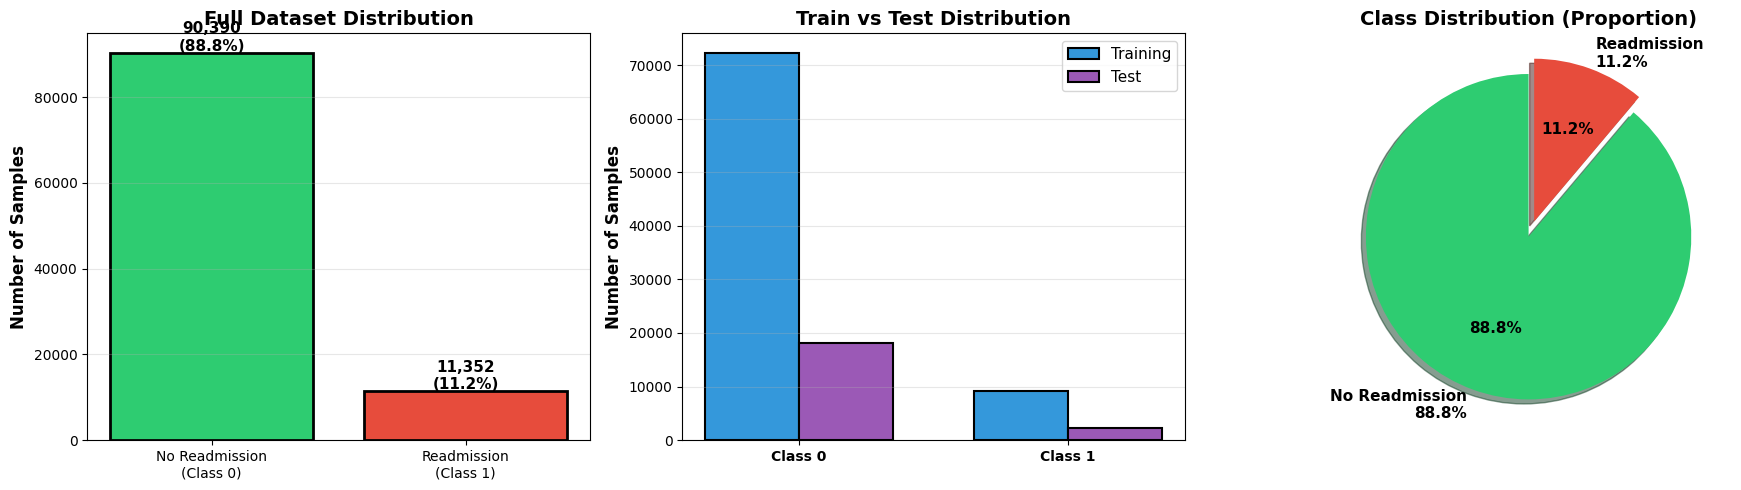


✅ Class imbalance analysis complete!


In [41]:
# Comprehensive Class Imbalance Analysis
print("="*90)
print("CLASS IMBALANCE ANALYSIS")
print("="*90)

# Full dataset
print("\n📊 FULL DATASET (After preprocessing):")
print("-" * 90)
full_counts = y.value_counts().sort_index()
full_percentages = y.value_counts(normalize=True).sort_index() * 100

print(f"Class 0 (No Readmission):  {full_counts[0]:,} samples ({full_percentages[0]:.2f}%)")
print(f"Class 1 (Readmission):     {full_counts[1]:,} samples ({full_percentages[1]:.2f}%)")
print(f"Total samples:             {len(y):,}")
print(f"\n⚖️ Imbalance Ratio (Class 0 : Class 1) = {full_counts[0]/full_counts[1]:.2f} : 1")
print(f"   Class 1 is the MINORITY class ({full_percentages[1]:.2f}% of total)")

# Training set
print("\n\n📊 TRAINING SET:")
print("-" * 90)
train_counts = y_train.value_counts().sort_index()
train_percentages = y_train.value_counts(normalize=True).sort_index() * 100

print(f"Class 0 (No Readmission):  {train_counts[0]:,} samples ({train_percentages[0]:.2f}%)")
print(f"Class 1 (Readmission):     {train_counts[1]:,} samples ({train_percentages[1]:.2f}%)")
print(f"Total samples:             {len(y_train):,}")
print(f"\n⚖️ Imbalance Ratio (Class 0 : Class 1) = {train_counts[0]/train_counts[1]:.2f} : 1")

# Test set
print("\n\n📊 TEST SET:")
print("-" * 90)
test_counts = y_test.value_counts().sort_index()
test_percentages = y_test.value_counts(normalize=True).sort_index() * 100

print(f"Class 0 (No Readmission):  {test_counts[0]:,} samples ({test_percentages[0]:.2f}%)")
print(f"Class 1 (Readmission):     {test_counts[1]:,} samples ({test_percentages[1]:.2f}%)")
print(f"Total samples:             {len(y_test):,}")
print(f"\n⚖️ Imbalance Ratio (Class 0 : Class 1) = {test_counts[0]/test_counts[1]:.2f} : 1")

# Imbalance severity assessment
print("\n\n" + "="*90)
print("IMBALANCE SEVERITY ASSESSMENT")
print("="*90)

minority_pct = full_percentages[1]

if minority_pct >= 40:
    severity = "✅ SLIGHT IMBALANCE"
    description = "Classes are relatively balanced"
    recommendation = "Standard algorithms should work well"
elif minority_pct >= 20:
    severity = "⚠️ MODERATE IMBALANCE"
    description = "Noticeable imbalance present"
    recommendation = "Consider class weights or stratified sampling"
elif minority_pct >= 10:
    severity = "🔶 HIGH IMBALANCE"
    description = "Significant imbalance - minority class underrepresented"
    recommendation = "Use class weights, SMOTE, or cost-sensitive learning"
else:
    severity = "🔴 SEVERE IMBALANCE"
    description = "Extreme imbalance - minority class critically underrepresented"
    recommendation = "Mandatory: Use specialized techniques (SMOTE, class weights, ensemble methods)"

print(f"\n{severity}")
print(f"Minority class: {minority_pct:.2f}% of dataset")
print(f"Imbalance ratio: {full_counts[0]/full_counts[1]:.2f}:1")
print(f"\n📝 Description: {description}")
print(f"💡 Recommendation: {recommendation}")

# Your approach
print("\n\n" + "="*90)
print("YOUR APPROACH TO HANDLE IMBALANCE")
print("="*90)
print("\n✅ You are using: CLASS WEIGHTS (is_unbalance=True in LightGBM)")
print("   This automatically adjusts the loss function to give more weight")
print("   to the minority class during training.")
print("\n❌ You are NOT using: SMOTE (Synthetic Minority Over-sampling)")
print("   SMOTE would create synthetic samples of the minority class.")
print("\n🎯 Result: Your model prioritizes RECALL over PRECISION")
print(f"   - Recall (Class 1): {model_results['LightGBM']['Recall (Class 1)']*100:.2f}%")
print(f"   - Precision (Class 1): {model_results['LightGBM']['Precision (Class 1)']*100:.2f}%")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Full dataset distribution
axes[0].bar(['No Readmission\n(Class 0)', 'Readmission\n(Class 1)'], 
            [full_counts[0], full_counts[1]], 
            color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)
axes[0].set_title('Full Dataset Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
for i, v in enumerate([full_counts[0], full_counts[1]]):
    axes[0].text(i, v + 500, f'{v:,}\n({[full_percentages[0], full_percentages[1]][i]:.1f}%)', 
                ha='center', fontsize=11, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Train vs Test comparison
x = np.arange(2)
width = 0.35
axes[1].bar(x - width/2, [train_counts[0], train_counts[1]], width, 
           label='Training', color='#3498db', edgecolor='black', linewidth=1.5)
axes[1].bar(x + width/2, [test_counts[0], test_counts[1]], width, 
           label='Test', color='#9b59b6', edgecolor='black', linewidth=1.5)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Class 0', 'Class 1'], fontweight='bold')
axes[1].set_title('Train vs Test Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

# Pie chart
colors_pie = ['#2ecc71', '#e74c3c']
explode = (0, 0.1)  # Explode the minority class
axes[2].pie([full_counts[0], full_counts[1]], 
           labels=[f'No Readmission\n{full_percentages[0]:.1f}%', 
                  f'Readmission\n{full_percentages[1]:.1f}%'],
           autopct='%1.1f%%', startangle=90, colors=colors_pie, 
           explode=explode, shadow=True, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[2].set_title('Class Distribution (Proportion)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*90)
print("✅ Class imbalance analysis complete!")
print("="*90)

## Project Workflow Diagram

✅ Combined workflow diagram saved as 'Diabetes_Readmission_Workflow_Combined.png'


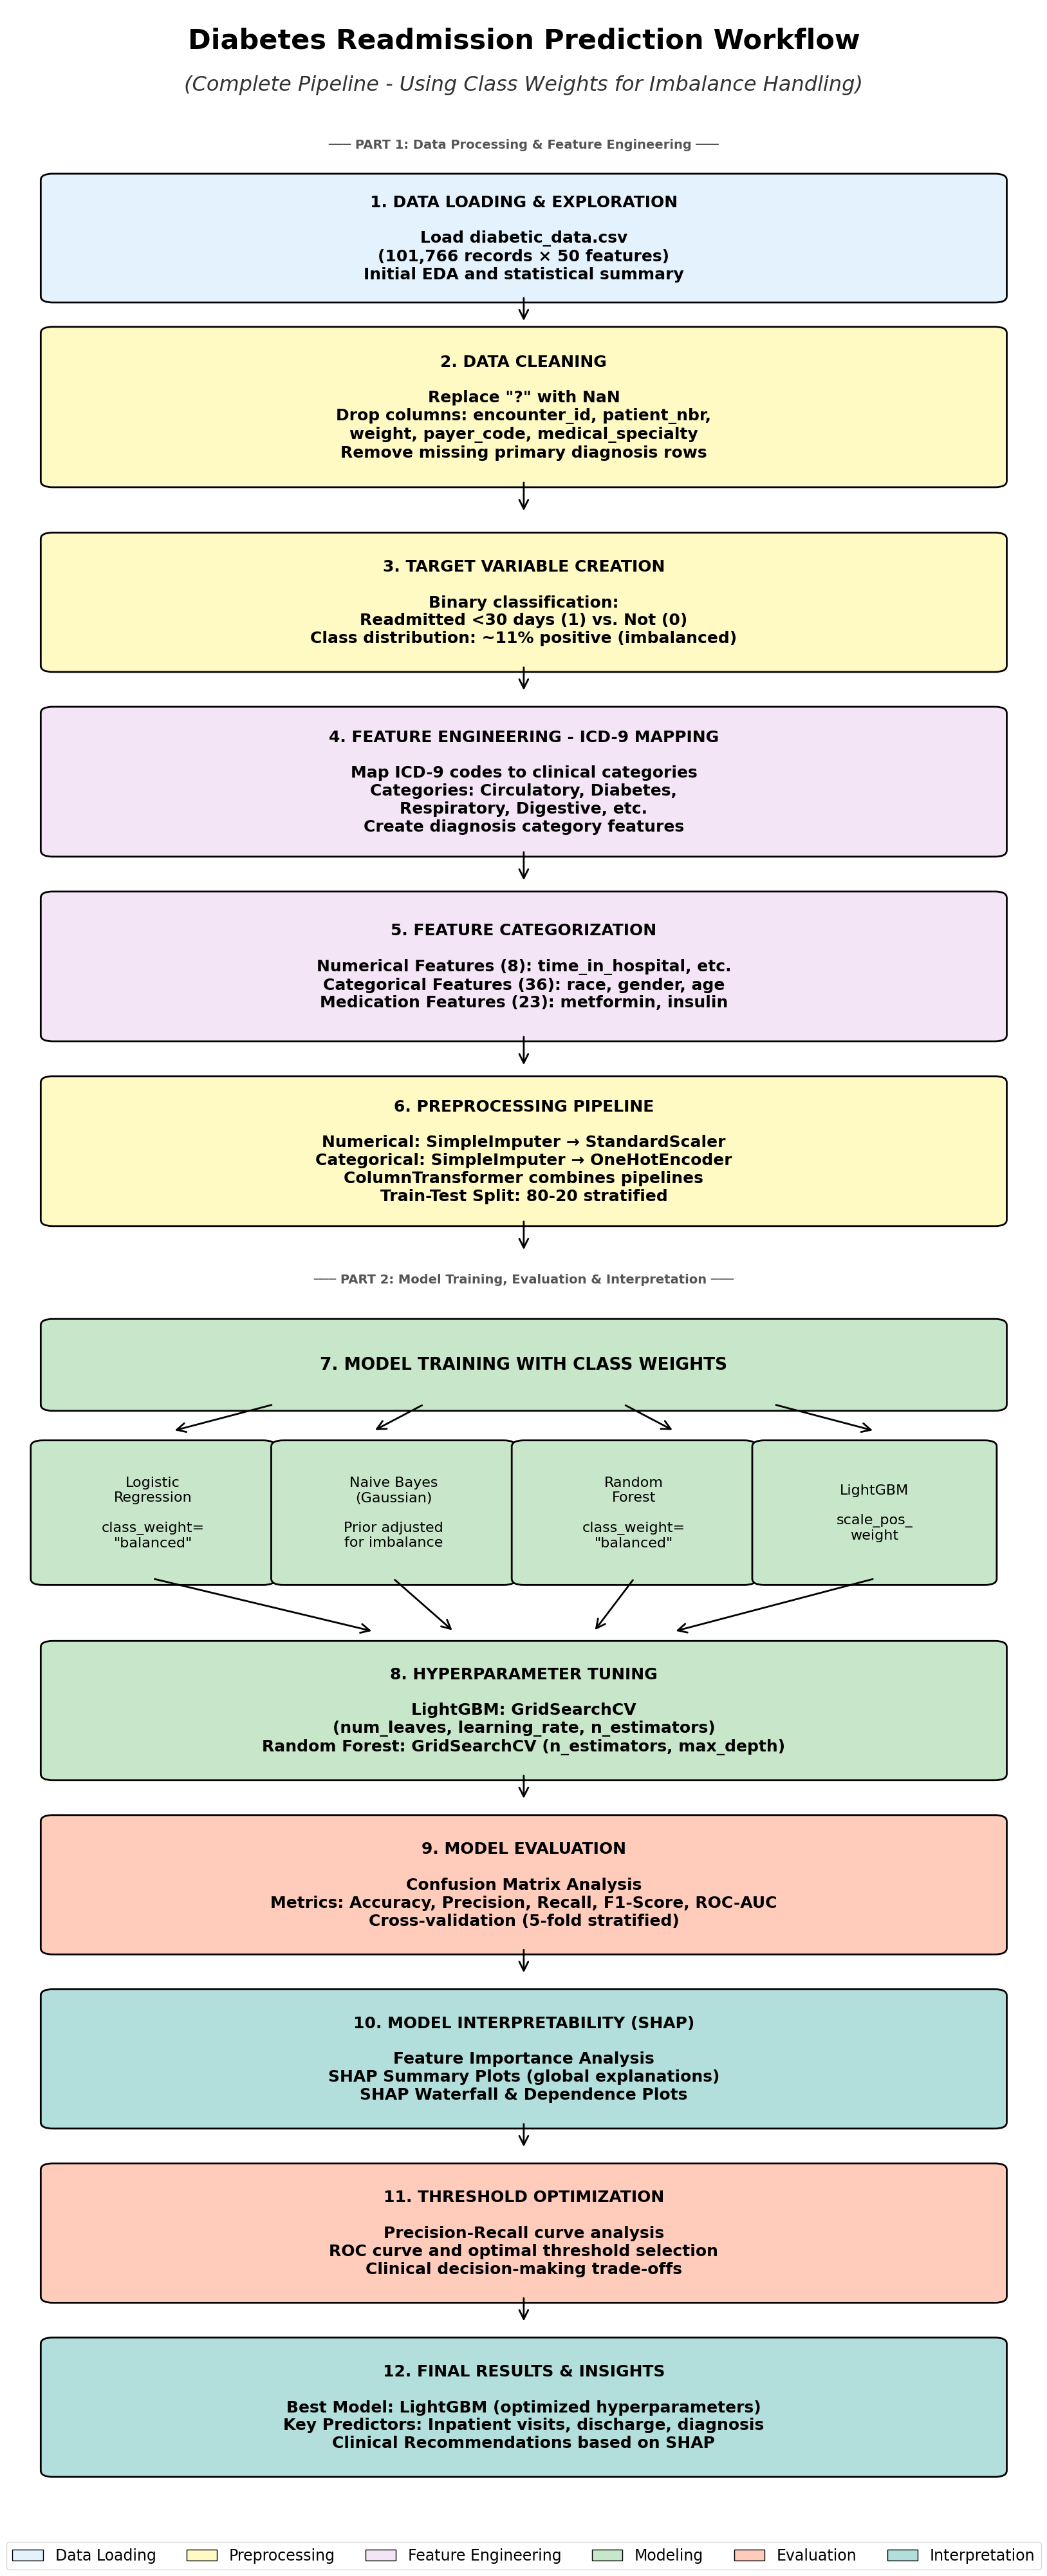


📊 COMBINED WORKFLOW DIAGRAM CREATED!
• All 12 steps in a single comprehensive image
• Part 1: Data Processing & Feature Engineering (Steps 1-6)
• Part 2: Model Training, Evaluation & Interpretation (Steps 7-12)
• Saved at 300 DPI for high-quality document use


In [10]:
# =====================================================
# COMBINED WORKFLOW DIAGRAM - ALL 12 STEPS IN ONE IMAGE
# =====================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

# Font sizes for document readability
TITLE_FS = 31
SUBTITLE_FS = 23
BOX_TITLE_FS = 18
MODEL_BOX_FS = 16
LEGEND_FS = 17

# Define colors
color_data = '#E3F2FD'
color_preprocessing = '#FFF9C4'
color_feature = '#F3E5F5'
color_model = '#C8E6C9'
color_evaluation = '#FFCCBC'
color_interpretation = '#B2DFDB'

# Helper function to create boxes
def create_box(ax, x, y, width, height, text, color, fontsize=BOX_TITLE_FS, fontweight='normal'):
    box = FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.12", 
                         edgecolor='black', facecolor=color, linewidth=2)
    ax.add_patch(box)
    ax.text(x + width/2, y + height/2, text, ha='center', va='center', 
            fontsize=fontsize, fontweight=fontweight, wrap=True, linespacing=1.2)

# Helper function for arrows
def create_arrow(ax, x1, y1, x2, y2):
    arrow = FancyArrowPatch((x1, y1), (x2, y2), 
                           arrowstyle='->', mutation_scale=25, 
                           linewidth=2, color='black')
    ax.add_patch(arrow)

# Create combined figure
fig, ax = plt.subplots(figsize=(18, 40))
ax.set_xlim(0, 10)
ax.set_ylim(0, 48)
ax.axis('off')

# Main Title
ax.text(5, 47.2, 'Diabetes Readmission Prediction Workflow', 
        fontsize=TITLE_FS, fontweight='bold', ha='center')
ax.text(5, 46.4, '(Complete Pipeline - Using Class Weights for Imbalance Handling)', 
        fontsize=SUBTITLE_FS, ha='center', style='italic', color='#333333')

# ==================== PART 1: Steps 1-6 ====================
ax.text(5, 45.3, '─── PART 1: Data Processing & Feature Engineering ───', 
        fontsize=14, ha='center', color='#555555', fontweight='bold')

# Phase 1: Data Loading & Exploration
y_pos = 42.5
create_box(ax, 0.3, y_pos, 9.4, 2.2, 
           '1. DATA LOADING & EXPLORATION\n\nLoad diabetic_data.csv\n(101,766 records × 50 features)\nInitial EDA and statistical summary',
           color_data, fontsize=BOX_TITLE_FS, fontweight='bold')
create_arrow(ax, 5, y_pos, 5, y_pos - 0.5)

# Phase 2: Data Cleaning
y_pos = 39.0
create_box(ax, 0.3, y_pos, 9.4, 2.8, 
           '2. DATA CLEANING\n\nReplace "?" with NaN\nDrop columns: encounter_id, patient_nbr,\nweight, payer_code, medical_specialty\nRemove missing primary diagnosis rows',
           color_preprocessing, fontsize=BOX_TITLE_FS, fontweight='bold')
create_arrow(ax, 5, y_pos, 5, y_pos - 0.6)

# Phase 3: Target Variable Creation
y_pos = 35.5
create_box(ax, 0.3, y_pos, 9.4, 2.4, 
           '3. TARGET VARIABLE CREATION\n\nBinary classification:\nReadmitted <30 days (1) vs. Not (0)\nClass distribution: ~11% positive (imbalanced)',
           color_preprocessing, fontsize=BOX_TITLE_FS, fontweight='bold')
create_arrow(ax, 5, y_pos, 5, y_pos - 0.5)

# Phase 4: Feature Engineering
y_pos = 32.0
create_box(ax, 0.3, y_pos, 9.4, 2.6, 
           '4. FEATURE ENGINEERING - ICD-9 MAPPING\n\nMap ICD-9 codes to clinical categories\nCategories: Circulatory, Diabetes,\nRespiratory, Digestive, etc.\nCreate diagnosis category features',
           color_feature, fontsize=BOX_TITLE_FS, fontweight='bold')
create_arrow(ax, 5, y_pos, 5, y_pos - 0.6)

# Phase 5: Feature Categorization
y_pos = 28.5
create_box(ax, 0.3, y_pos, 9.4, 2.6, 
           '5. FEATURE CATEGORIZATION\n\nNumerical Features (8): time_in_hospital, etc.\nCategorical Features (36): race, gender, age\nMedication Features (23): metformin, insulin',
           color_feature, fontsize=BOX_TITLE_FS, fontweight='bold')
create_arrow(ax, 5, y_pos, 5, y_pos - 0.6)

# Phase 6: Preprocessing Pipeline
y_pos = 25.0
create_box(ax, 0.3, y_pos, 9.4, 2.6, 
           '6. PREPROCESSING PIPELINE\n\nNumerical: SimpleImputer → StandardScaler\nCategorical: SimpleImputer → OneHotEncoder\nColumnTransformer combines pipelines\nTrain-Test Split: 80-20 stratified',
           color_preprocessing, fontsize=BOX_TITLE_FS, fontweight='bold')
create_arrow(ax, 5, y_pos, 5, y_pos - 0.6)

# ==================== PART 2: Steps 7-12 ====================
ax.text(5, 23.8, '─── PART 2: Model Training, Evaluation & Interpretation ───', 
        fontsize=14, ha='center', color='#555555', fontweight='bold')

# Phase 7: Model Training Header
y_pos = 21.5
create_box(ax, 0.3, y_pos, 9.4, 1.5, 
           '7. MODEL TRAINING WITH CLASS WEIGHTS',
           color_model, fontsize=BOX_TITLE_FS+1, fontweight='bold')

# Arrow splits into 4
create_arrow(ax, 2.5, y_pos, 1.5, y_pos - 0.5)
create_arrow(ax, 4, y_pos, 3.5, y_pos - 0.5)
create_arrow(ax, 6, y_pos, 6.5, y_pos - 0.5)
create_arrow(ax, 7.5, y_pos, 8.5, y_pos - 0.5)

# Four models
y_pos = 18.2
box_width = 2.2
create_box(ax, 0.2, y_pos, box_width, 2.5, 
           'Logistic\nRegression\n\nclass_weight=\n"balanced"',
           color_model, fontsize=MODEL_BOX_FS)
create_box(ax, 2.6, y_pos, box_width, 2.5, 
           'Naive Bayes\n(Gaussian)\n\nPrior adjusted\nfor imbalance',
           color_model, fontsize=MODEL_BOX_FS)
create_box(ax, 5.0, y_pos, box_width, 2.5, 
           'Random\nForest\n\nclass_weight=\n"balanced"',
           color_model, fontsize=MODEL_BOX_FS)
create_box(ax, 7.4, y_pos, box_width, 2.5, 
           'LightGBM\n\nscale_pos_\nweight',
           color_model, fontsize=MODEL_BOX_FS)

# Arrows converge
create_arrow(ax, 1.3, y_pos, 3.5, y_pos - 1)
create_arrow(ax, 3.7, y_pos, 4.3, y_pos - 1)
create_arrow(ax, 6.1, y_pos, 5.7, y_pos - 1)
create_arrow(ax, 8.5, y_pos, 6.5, y_pos - 1)

# Phase 8: Hyperparameter Tuning
y_pos = 14.5
create_box(ax, 0.3, y_pos, 9.4, 2.4, 
           '8. HYPERPARAMETER TUNING\n\nLightGBM: GridSearchCV\n(num_leaves, learning_rate, n_estimators)\nRandom Forest: GridSearchCV (n_estimators, max_depth)',
           color_model, fontsize=BOX_TITLE_FS, fontweight='bold')
create_arrow(ax, 5, y_pos, 5, y_pos - 0.5)

# Phase 9: Model Evaluation
y_pos = 11.2
create_box(ax, 0.3, y_pos, 9.4, 2.4, 
           '9. MODEL EVALUATION\n\nConfusion Matrix Analysis\nMetrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC\nCross-validation (5-fold stratified)',
           color_evaluation, fontsize=BOX_TITLE_FS, fontweight='bold')
create_arrow(ax, 5, y_pos, 5, y_pos - 0.5)

# Phase 10: Model Interpretability
y_pos = 7.9
create_box(ax, 0.3, y_pos, 9.4, 2.4, 
           '10. MODEL INTERPRETABILITY (SHAP)\n\nFeature Importance Analysis\nSHAP Summary Plots (global explanations)\nSHAP Waterfall & Dependence Plots',
           color_interpretation, fontsize=BOX_TITLE_FS, fontweight='bold')
create_arrow(ax, 5, y_pos, 5, y_pos - 0.5)

# Phase 11: Threshold Optimization
y_pos = 4.6
create_box(ax, 0.3, y_pos, 9.4, 2.4, 
           '11. THRESHOLD OPTIMIZATION\n\nPrecision-Recall curve analysis\nROC curve and optimal threshold selection\nClinical decision-making trade-offs',
           color_evaluation, fontsize=BOX_TITLE_FS, fontweight='bold')
create_arrow(ax, 5, y_pos, 5, y_pos - 0.5)

# Phase 12: Final Results & Insights
y_pos = 1.3
create_box(ax, 0.3, y_pos, 9.4, 2.4, 
           '12. FINAL RESULTS & INSIGHTS\n\nBest Model: LightGBM (optimized hyperparameters)\nKey Predictors: Inpatient visits, discharge, diagnosis\nClinical Recommendations based on SHAP',
           color_interpretation, fontsize=BOX_TITLE_FS, fontweight='bold')

# Add legend at the bottom
legend_elements = [
    mpatches.Patch(facecolor=color_data, edgecolor='black', label='Data Loading'),
    mpatches.Patch(facecolor=color_preprocessing, edgecolor='black', label='Preprocessing'),
    mpatches.Patch(facecolor=color_feature, edgecolor='black', label='Feature Engineering'),
    mpatches.Patch(facecolor=color_model, edgecolor='black', label='Modeling'),
    mpatches.Patch(facecolor=color_evaluation, edgecolor='black', label='Evaluation'),
    mpatches.Patch(facecolor=color_interpretation, edgecolor='black', label='Interpretation')
]
ax.legend(handles=legend_elements, loc='lower center', ncol=6, 
         bbox_to_anchor=(0.5, -0.015), fontsize=LEGEND_FS, frameon=True)

plt.tight_layout()
plt.savefig('Diabetes_Readmission_Workflow_Combined.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Combined workflow diagram saved as 'Diabetes_Readmission_Workflow_Combined.png'")
plt.show()

print("\n" + "="*60)
print("📊 COMBINED WORKFLOW DIAGRAM CREATED!")
print("="*60)
print("• All 12 steps in a single comprehensive image")
print("• Part 1: Data Processing & Feature Engineering (Steps 1-6)")
print("• Part 2: Model Training, Evaluation & Interpretation (Steps 7-12)")
print("• Saved at 300 DPI for high-quality document use")
print("="*60)